In [27]:
import pandas as pd
from sqlalchemy import create_engine, text


# 데이터베이스 연결 설정
def connect_to_database():
    # 데이터베이스 연결 정보
    username = "biztour"
    password = "admin123$%^"
    hostname = "110.45.210.144"
    port = 63306
    database = "BIZDB"

    # SQLAlchemy 엔진 생성
    engine = create_engine(
        f"mysql+pymysql://{username}:{password}@{hostname}:{port}/{database}"
    )
    return engine

### 상품관리 테이블
-----
#### HANA_PRODUCTMASTER 
* 대표상품코드
* 대표상품명
* 공급사명
* 방문국가코드
* 방문도시코드
* 여행박수
* 여행일수
* 자유일정유무
* 쇼핑횟수
* etc

#### HANA_PRODUCTEVENT
* 대표상품코드
* 항공사코드
* 항공사명
* 호텔등급
* 상품테마
* 상품가격
* etc

#### HANA_TOTAL_RESERVATION
* 예약정보

In [53]:
import pandas as pd
import numpy as np
from sqlalchemy import create_engine, text


# 여러 테이블의 데이터를 가져오는 함수
def fetch_multiple_tables(engine, table_names):
    data_frames = {}
    for table_name in table_names:
        fetch_query = f"SELECT * FROM {table_name}"
        df = pd.read_sql(text(fetch_query), engine)
        data_frames[table_name] = df
    return data_frames


engine = connect_to_database()
# 사용 예시
table_names = ["HANA_TOTAL_RESERVATION", "HANA_TOTAL_PASSENGER", "HANA_TOTAL_PAYMENT"]
data_frames = fetch_multiple_tables(engine, table_names)

# 특정 테이블에 접근
hana_reservation_df = data_frames["HANA_TOTAL_RESERVATION"]
hana_reservation_df = hana_reservation_df[
    (hana_reservation_df["RESERVATIONSTATUS"] == "12")
    & (hana_reservation_df["TYPE"] != "H")
]


print(hana_reservation_df)

merge_left = pd.merge(
    hana_reservation_df,
    data_frames["HANA_TOTAL_PAYMENT"],
    how="left",
    left_on="SEQNO",
    right_on="SEQNO",
)

print(merge_left)

missing_amount_count = merge_left["AMOUNT"].isna().sum()
print(f"Number of missing values in the 'AMOUNT' column: {missing_amount_count}")


# 결측값이 있는 행 제거
merge_left1 = merge_left.dropna(subset=["AMOUNT"])
print("Dataframe after removing rows with missing 'AMOUNT' values:")
print(merge_left1)

        SEQNO  CHANNELSEQNO RESERVATIONCODE INTERALRESERVATIONCODE  \
22      47505           2.0        44338260          2023061414609   
209     47692           2.0   2023061314351          2023061314351   
454     47937           2.0         7552150          2023061214161   
528     48011           2.0        44323739          2023061214265   
609     48092           2.0   2023061214312          2023061214312   
...       ...           ...             ...                    ...   
86596  137680           2.0         8282682             RVWT000178   
86689  137773          24.0    HP2417520934             RPHN001388   
86764  137848           2.0         8285003             RPWT000160   
86844  137928           2.0        46775409             RAMO000539   
87050  138134           2.0        46784529             RPMO001472   

          RESERVATIONDATE RESERVATIONSTATUS BOOKERNAME BOOKERPHONETYPE  \
22    2023-06-14 00:00:00                12        김민규               1   
209   2023-


하나투어 비즈니스 경영진 입장에서 보고싶어하는 정보? 

단순 매출정보 이외에 보여줄만한 것

오투어에 예약되는 상품중 선호되는 리스트를 정리해서, 해당 부문을 강화할 수 있도록?

주로 어떤 시간대의 상품들이 많이 예약되는지, (시간대, 요일 정보 등?)

혹은 공휴일에 예약되는 비율이 평소 예약되는 비율의 몇퍼센트인지

매출비율 (에어텔, 자유일정유무)

쇼핑횟수별 판매율, 몇박 몇일 상품이 잘나가는지

주로 많이나가는 가격대

C:\Users\douly\AppData\Local\Temp\ipykernel_46496\3249032614.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  merge_left1["DEPARTUREDAY"] = pd.to_datetime(
C:\Users\douly\AppData\Local\Temp\ipykernel_46496\3249032614.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  merge_left1["DEPARTURETIME"] = pd.to_datetime(
C:\Users\douly\AppData\Local\Temp\ipykernel_46496\3249032614.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_i

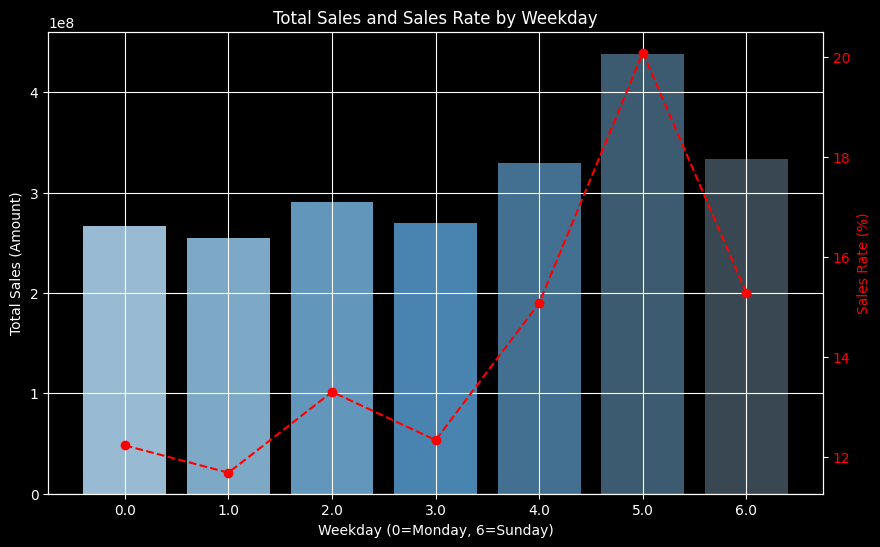

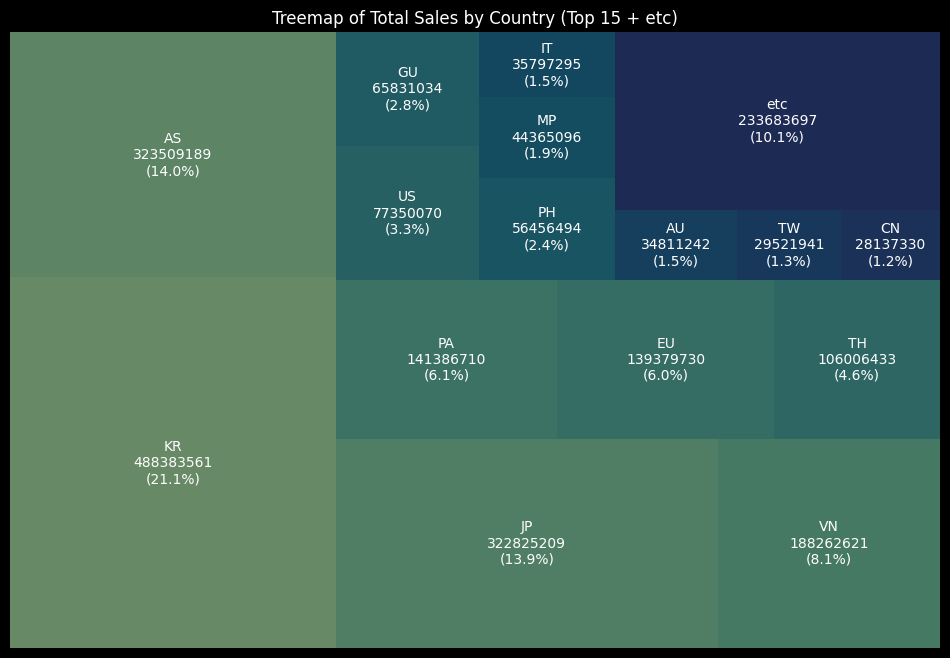

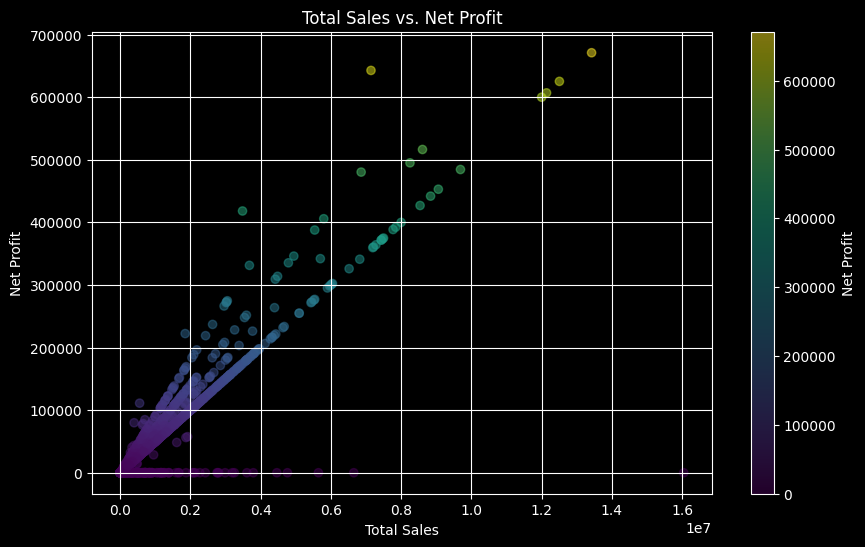

C:\Users\douly\AppData\Local\Temp\ipykernel_46496\3249032614.py:107: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=weekday_net_profit.index, y=weekday_net_profit.values, palette="Greens_d")


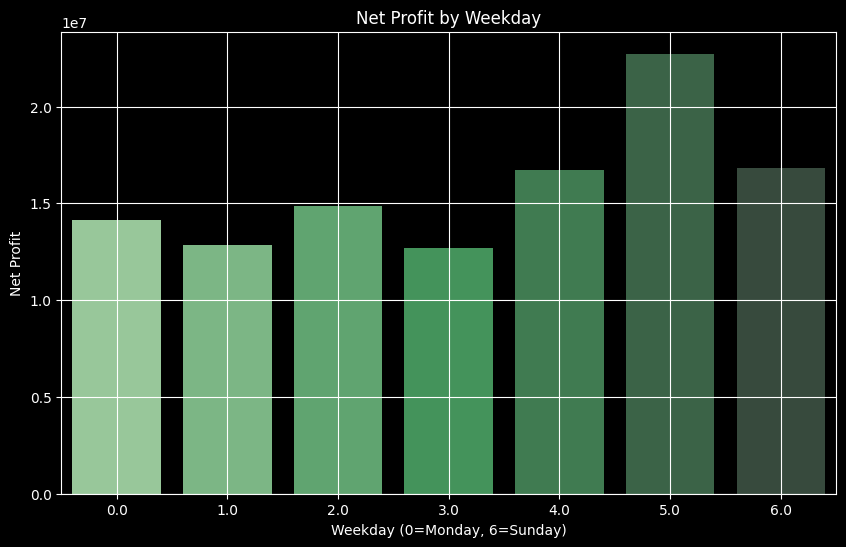

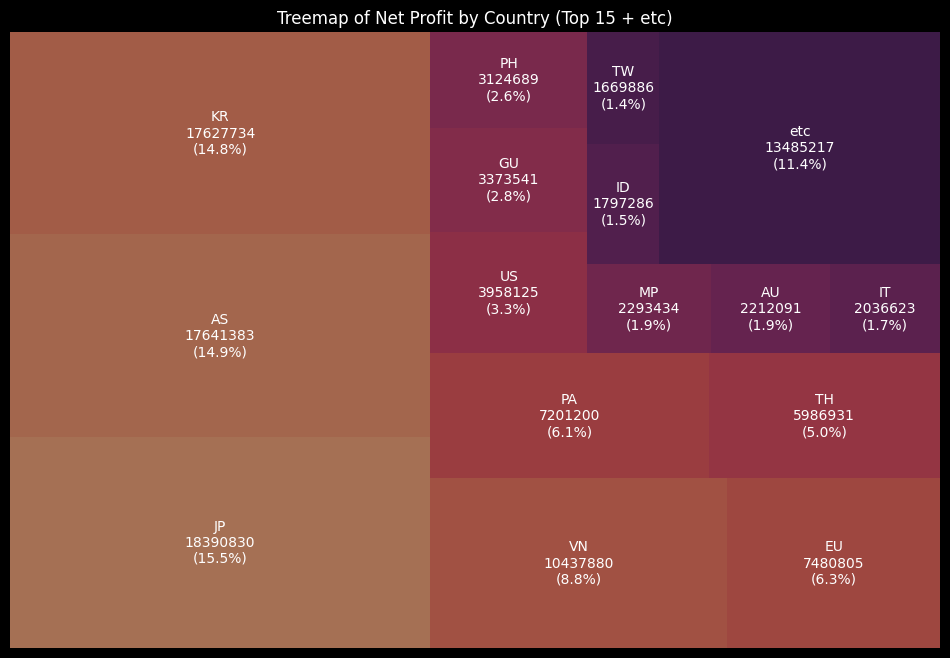

In [75]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import squarify
from datetime import datetime, timedelta

# Parsing DEPARTUREDAY as datetime with format inference
merge_left1["DEPARTUREDAY"] = pd.to_datetime(
    merge_left1["DEPARTUREDAY"], errors="coerce"
)
merge_left1["DEPARTURETIME"] = pd.to_datetime(
    merge_left1["DEPARTURETIME"], errors="coerce"
)

# Extracting hour and weekday for time-based analysis
merge_left1["WEEKDAY"] = merge_left1["DEPARTUREDAY"].dt.weekday

# 매출량 (AMOUNT)과 순수익 계산
merge_left1["TOTAL_SALES"] = merge_left1["AMOUNT"]
merge_left1["NET_PROFIT"] = merge_left1["AMOUNT"] * (merge_left1["PRODUCTRATE"] / 100)

# 요일별 매출 분석
weekday_sales = merge_left1.groupby("WEEKDAY")["TOTAL_SALES"].sum()
weekday_net_profit = merge_left1.groupby("WEEKDAY")["NET_PROFIT"].sum()

# 요일별 매출 비율 계산
total_sales = weekday_sales.sum()
weekday_sales_rate = (weekday_sales / total_sales) * 100

# 요일별 총 수익 Bar Chart와 매출 비율 Line Chart 추가
plt.figure(figsize=(10, 6))
ax1 = sns.barplot(x=weekday_sales.index, y=weekday_sales.values, palette="Blues_d")

# 첫 번째 y축 (왼쪽) - 요일별 매출
ax1.set_xlabel("Weekday (0=Monday, 6=Sunday)")
ax1.set_ylabel("Total Sales (Amount)")
ax1.set_title("Total Sales and Sales Rate by Weekday")

# 두 번째 y축 (오른쪽) - 요일별 매출 비율 (line chart)
ax2 = ax1.twinx()
ax2.plot(
    weekday_sales.index,
    weekday_sales_rate.values,
    color="r",
    marker="o",
    linestyle="--",
    label="Sales Rate (%)",
)
ax2.set_ylabel("Sales Rate (%)", color="r")
ax2.tick_params(axis="y", labelcolor="r")

# 그리드 및 레전드 추가
ax1.grid(True)
plt.show()


# 국가별 총 수익 트리맵
country_sales = merge_left1.groupby("COUNTRYCODE")["TOTAL_SALES"].sum()

# 상위 15개 국가 선택
top_15_countries = country_sales.nlargest(15)

# 나머지 국가의 매출 합계 (etc로 처리)
other_countries_sales = country_sales.sum() - top_15_countries.sum()

# 상위 15개 국가와 기타 국가 합치기
top_15_countries["etc"] = other_countries_sales

total_sales = top_15_countries.sum()
labels = [
    f"{country}\n{value:.0f}\n({value/total_sales:.1%})"
    for country, value in top_15_countries.items()
]

# 트리맵 그리기
plt.figure(figsize=(12, 8))
squarify.plot(
    sizes=top_15_countries.values,
    label=labels,
    alpha=0.7,
    color=sns.color_palette("crest", len(top_15_countries)),
)
plt.title("Treemap of Total Sales by Country (Top 15 + etc)")
plt.axis("off")
plt.show()

# 총수익과 순수익을 결합한 산점도
plt.figure(figsize=(10, 6))
plt.scatter(
    merge_left1["TOTAL_SALES"],
    merge_left1["NET_PROFIT"],
    alpha=0.5,
    c=merge_left1["NET_PROFIT"],
    cmap="viridis",
)
plt.colorbar(label="Net Profit")
plt.xlabel("Total Sales")
plt.ylabel("Net Profit")
plt.title("Total Sales vs. Net Profit")
plt.grid(True)
plt.show()

# 요일별 순수익 바차트
plt.figure(figsize=(10, 6))
weekday_net_profit = merge_left1.groupby("WEEKDAY")["NET_PROFIT"].sum()
sns.barplot(x=weekday_net_profit.index, y=weekday_net_profit.values, palette="Greens_d")
plt.xlabel("Weekday (0=Monday, 6=Sunday)")
plt.ylabel("Net Profit")
plt.title("Net Profit by Weekday")
plt.grid(True)
plt.show()

# 국가별 순수익 트리맵
country_net_profit = merge_left1.groupby("COUNTRYCODE")["NET_PROFIT"].sum()

# 상위 15개 국가 선택
top_15_net_profit_countries = country_net_profit.nlargest(15)

# 나머지 국가 순수익 합계 (etc로 처리)
other_net_profit_countries = (
    country_net_profit.sum() - top_15_net_profit_countries.sum()
)

# 상위 15개 국가와 기타 국가 합치기
top_15_net_profit_countries["etc"] = other_net_profit_countries

# 국가별 순수익 트리맵
total_net_profit = top_15_net_profit_countries.sum()
labels_net_profit = [
    f"{country}\n{value:.0f}\n({value/total_net_profit:.1%})"
    for country, value in top_15_net_profit_countries.items()
]

# 순수익 트리맵 그리기
plt.figure(figsize=(12, 8))
squarify.plot(
    sizes=top_15_net_profit_countries.values,
    label=labels_net_profit,
    alpha=0.7,
    color=sns.color_palette("flare", len(top_15_net_profit_countries)),
)
plt.title("Treemap of Net Profit by Country (Top 15 + etc)")
plt.axis("off")
plt.show()

In [57]:
import pandas as pd
import plotly.graph_objs as go
import plotly.io as pio

# Plotly 다크모드 테마 설정
pio.templates.default = "plotly_dark"

# DB 연결
engine = connect_to_database()

# SQL 쿼리 실행
query = """
SELECT 
    PRODUCTCODE,
    CASE 
        WHEN PRODUCTCODE LIKE 'H%' THEN 'Hotel'
        ELSE 'Package'
    END AS PRODUCT_TYPE
FROM YOUR_TABLE_NAME;
"""

# SQL 결과를 Pandas DataFrame으로 가져오기
df = pd.read_sql(query, engine)


# 호텔과 패키지 상품의 비율 계산
product_type_counts = df["PRODUCT_TYPE"].value_counts()

# Pie chart 데이터 준비
labels = product_type_counts.index
values = product_type_counts.values

# 다크모드에 어울리는 선명한 색상 팔레트 설정
colors = ["#636EFA", "#EF553B"]  # 선명한 파란색과 빨간색 사용

# Plotly Pie chart 생성
fig = go.Figure(
    go.Pie(
        labels=labels,
        values=values,
        textinfo="label+percent+value",  # 라벨, 비율, 수량 모두 표시
        texttemplate="%{label}: %{percent:.1%} (%{value})",  # 사용자 지정 텍스트 템플릿
        insidetextorientation="radial",
        marker=dict(
            colors=colors, line=dict(color="#FFFFFF", width=2)
        ),  # 색상과 테두리 설정
    )
)

# 레이아웃 설정 (다크 테마 및 디자인적 요소 강화)
fig.update_layout(
    title={
        "text": "Hotel vs Package Product Ratio",
        "y": 0.9,
        "x": 0.5,
        "xanchor": "center",
        "yanchor": "top",
        "font": dict(size=24, color="white"),  # 제목 폰트 크기와 색상
    },
    annotations=[
        dict(
            text="",
            x=0.5,
            y=-0.1,
            font_size=16,
            showarrow=False,
            font=dict(color="lightgrey"),  # 하단에 부가 설명 추가
        )
    ],
    height=700,
    width=800,
    template="plotly_dark",  # 테마 적용
    plot_bgcolor="#1f2c56",  # 플롯 배경 색상 설정
    paper_bgcolor="#1f2c56",  # 전체 배경 색상 설정
    margin=dict(t=140, b=100, l=100, r=50),  # 여백 조정
)

# 그래프 출력
fig.show()

ValueError: unsupported format character ''' (0x27) at index 69

In [3]:
from flask import Flask, render_template
import pandas as pd
from sqlalchemy import create_engine

app = Flask(__name__)

# DB 연결
engine = connect_to_database()


@app.route("/")
def index():
    # SQL 쿼리를 실행하여 데이터 불러오기
    query = "SELECT * FROM HANA_TOTAL_RESERVATION"  # 예시 쿼리
    df = pd.read_sql(query, engine)

    # 데이터 전처리: 'H'로 시작하는 것은 '호텔', 그 외는 '패키지', 결측값은 'etc'로 분류
    df["PRODUCT_TYPE"] = df["PRODUCTCODE"].apply(
        lambda x: (
            "Hotel"
            if isinstance(x, str) and x.startswith("H")
            else ("Package" if isinstance(x, str) else "etc")
        )
    )

    # 제품 유형별 비율 계산
    product_type_counts = df["PRODUCT_TYPE"].value_counts().to_dict()

    print(product_type_counts)

    # 분석 결과를 템플릿에 전달
    return render_template("index.html", product_type_counts=product_type_counts)


if __name__ == "__main__":
    app.run(debug=True, port=5001)

 * Serving Flask app '__main__'
 * Debug mode: on


 * Running on http://127.0.0.1:5001
Press CTRL+C to quit
 * Restarting with stat


SystemExit: 1

c:\Users\douly\AppData\Local\pypoetry\Cache\virtualenvs\biztour-2MXTw1DY-py3.11\Lib\site-packages\IPython\core\interactiveshell.py:3561: UserWarning: To exit: use 'exit', 'quit', or Ctrl-D.
  warn("To exit: use 'exit', 'quit', or Ctrl-D.", stacklevel=1)


In [29]:
query = """
SELECT 
    hhsp.SALEPRODUCTCODE,
    hhsp.DEPARTUREDAY,
    hhsp.AIRLINENAME,
    hhsp.ARRIVALAIRPORTCODE,
    hhsp.TRAVELNIGHTCOUNT,
    hhsp.TRAVELDAYCOUNT,
    hhsp.SHOPPINGCENTERVISITCOUNT,
    hhsp.FREEDOMSCHEDULEYN,
    hhsp.PRICEPRODUCT,
    hhsp.SUPPLIERCODE
FROM HANA_HANATOUR_SALE_PRODUCT hhsp
JOIN (
    SELECT PRODUCTCODE 
    FROM HANA_TOTAL_RESERVATION 
    WHERE RESERVATIONSTATUS = '12' 
      AND `TYPE` != 'H'
) reservation
ON hhsp.SALEPRODUCTCODE = reservation.PRODUCTCODE
UNION ALL
SELECT 
    hmsp.SALEPRODUCTCODE,
    hmsp.DEPARTUREDAY,
    hmsp.AIRLINENAME,
    hmsp.ARRIVALAIRPORTCODE,
    hmsp.TRAVELNIGHTCOUNT,
    hmsp.TRAVELDAYCOUNT,
    hmsp.SHOPPINGCENTERVISITCOUNT,
    hmsp.FREEDOMSCHEDULEYN,
    hmsp.PRICEPRODUCT,
    hmsp.SUPPLIERCODE
FROM HANA_MODETOUR_SALE_PRODUCT hmsp
JOIN (
    SELECT PRODUCTCODE 
    FROM HANA_TOTAL_RESERVATION 
    WHERE RESERVATIONSTATUS = '12' 
      AND `TYPE` != 'H'
) reservation
ON hmsp.SALEPRODUCTCODE = reservation.PRODUCTCODE;
"""

# SQL 쿼리 실행 후 결과를 DataFrame으로 가져오기
union_df = pd.read_sql_query(query, engine)

# 결과 출력
print(union_df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1075 entries, 0 to 1074
Data columns (total 10 columns):
 #   Column                    Non-Null Count  Dtype 
---  ------                    --------------  ----- 
 0   SALEPRODUCTCODE           1075 non-null   object
 1   DEPARTUREDAY              1075 non-null   object
 2   AIRLINENAME               1075 non-null   object
 3   ARRIVALAIRPORTCODE        1075 non-null   object
 4   TRAVELNIGHTCOUNT          1075 non-null   object
 5   TRAVELDAYCOUNT            1075 non-null   object
 6   SHOPPINGCENTERVISITCOUNT  1075 non-null   object
 7   FREEDOMSCHEDULEYN         1075 non-null   object
 8   PRICEPRODUCT              1075 non-null   object
 9   SUPPLIERCODE              1075 non-null   object
dtypes: object(10)
memory usage: 84.1+ KB
None


C:\Users\douly\AppData\Local\Temp\ipykernel_4344\3763329231.py:22: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  union_df["AIRLINENAME"].fillna("Unknown", inplace=True)
C:\Users\douly\AppData\Local\Temp\ipykernel_4344\3763329231.py:23: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.



Epoch 1/100
19/19 [==============================] - 1s 12ms/step - loss: 1.0793 - mean_squared_error: 0.9602 - val_loss: 1.8760 - val_mean_squared_error: 1.7636
Epoch 2/100
19/19 [==============================] - 0s 3ms/step - loss: 0.5576 - mean_squared_error: 0.4496 - val_loss: 1.4829 - val_mean_squared_error: 1.3797
Epoch 3/100
19/19 [==============================] - 0s 3ms/step - loss: 0.4595 - mean_squared_error: 0.3600 - val_loss: 1.4695 - val_mean_squared_error: 1.3740
Epoch 4/100
19/19 [==============================] - 0s 3ms/step - loss: 0.4185 - mean_squared_error: 0.3258 - val_loss: 1.4578 - val_mean_squared_error: 1.3680
Epoch 5/100
19/19 [==============================] - 0s 3ms/step - loss: 0.3921 - mean_squared_error: 0.3045 - val_loss: 1.4614 - val_mean_squared_error: 1.3761
Epoch 6/100
19/19 [==============================] - 0s 3ms/step - loss: 0.3591 - mean_squared_error: 0.2755 - val_loss: 1.4756 - val_mean_squared_error: 1.3940
Epoch 7/100
19/19 [==============

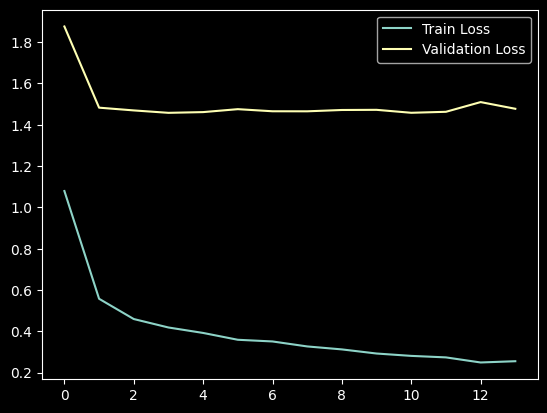

In [5]:
import json
import pandas as pd
import numpy as np

# 'union_df'는 데이터프레임입니다.

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.regularizers import l2

# SALEPRODUCTCODE를 기준으로 판매량 카운트 (판매량 = SALEPRODUCTCODE의 빈도)
union_df["SALE_COUNT"] = union_df.groupby("SALEPRODUCTCODE")[
    "SALEPRODUCTCODE"
].transform("count")

# SALE_COUNT를 수치형으로 변환
union_df["SALE_COUNT"] = pd.to_numeric(union_df["SALE_COUNT"], errors="coerce")

# 결측치 처리 (범주형 변수는 'Unknown'으로, 수치형 변수는 0으로)
union_df["AIRLINENAME"].fillna("Unknown", inplace=True)
union_df["ARRIVALAIRPORTCODE"].fillna("Unknown", inplace=True)
union_df["FREEDOMSCHEDULEYN"].fillna("N", inplace=True)
union_df.fillna(0, inplace=True)  # 나머지 수치형 데이터는 0으로 대체

# DEPARTUREDAY를 datetime 형식으로 파싱
union_df["DEPARTUREDAY"] = pd.to_datetime(union_df["DEPARTUREDAY"], errors="coerce")

# 시간 기반 분석을 위한 요일 추출
union_df["WEEKDAY"] = union_df["DEPARTUREDAY"].dt.weekday

# 범주형 변수 인코딩 (OneHotEncoder 사용)
categorical_columns = [
    "AIRLINENAME",
    "ARRIVALAIRPORTCODE",
    "WEEKDAY",
    "FREEDOMSCHEDULEYN",
]
encoder = OneHotEncoder(sparse_output=False)
encoded_categorical = encoder.fit_transform(union_df[categorical_columns].astype(str))

# 인코딩된 데이터프레임 생성
encoded_df_categorical = pd.DataFrame(
    encoded_categorical, columns=encoder.get_feature_names_out(categorical_columns)
)

# 원본 데이터프레임과 인코딩된 데이터프레임 병합
encoded_df = pd.concat(
    [union_df.reset_index(drop=True), encoded_df_categorical.reset_index(drop=True)],
    axis=1,
)


# 'PRICEPRODUCT' 열에서 'ageDivisionCode'가 'A'인 'amount' 추출 함수 정의
def parse_A_amount(json_string):
    try:
        parsed_data = json.loads(json_string)
        for entry in parsed_data:
            if entry["ageDivisionCode"] == "A":
                return entry["amount"]
    except (TypeError, json.JSONDecodeError):
        return 0  # JSON 파싱 실패 시 0 반환
    return 0  # 'A' 항목이 없을 경우 0 반환


# 'PRICEPRODUCT' 열에서 'A'의 amount를 추출하여 새로운 'A_AMOUNT' 열 생성
encoded_df["A_AMOUNT"] = encoded_df["PRICEPRODUCT"].apply(parse_A_amount)

# 사용할 특성 선택
encoded_feature_cols = encoder.get_feature_names_out(categorical_columns)
features = ["TRAVELDAYCOUNT", "SHOPPINGCENTERVISITCOUNT", "A_AMOUNT"] + list(
    encoded_feature_cols
)

# X: 특성 변수, y: 판매량 (SALE_COUNT)
X = encoded_df[features]
y = encoded_df["SALE_COUNT"]

# SALEPRODUCTCODE 기준으로 중복되지 않도록 훈련/테스트 데이터 분리
unique_product_codes = union_df["SALEPRODUCTCODE"].unique()
train_codes, test_codes = train_test_split(
    unique_product_codes, test_size=0.3, random_state=23
)

# 훈련/테스트 데이터로 분리
train_df = encoded_df[encoded_df["SALEPRODUCTCODE"].isin(train_codes)]
test_df = encoded_df[encoded_df["SALEPRODUCTCODE"].isin(test_codes)]

# 특성(X)과 타겟(y) 변수 추출
X_train = train_df[features]
y_train = train_df["SALE_COUNT"]
X_test = test_df[features]
y_test = test_df["SALE_COUNT"]

# 결측치 처리 (수치형 변수는 0으로 대체)
X_train = X_train.fillna(0)
X_test = X_test.fillna(0)

# 수치형 및 범주형 특성 분리
numerical_features = ["TRAVELDAYCOUNT", "SHOPPINGCENTERVISITCOUNT", "A_AMOUNT"]
categorical_features = encoded_feature_cols

# 수치형 특성 스케일링
scaler = StandardScaler()
X_train_num = scaler.fit_transform(X_train[numerical_features])
X_test_num = scaler.transform(X_test[numerical_features])

# 범주형 특성 배열화
X_train_cat = X_train[categorical_features].values
X_test_cat = X_test[categorical_features].values

# 데이터 타입 변환 (float32)
X_train_num = X_train_num.astype(np.float32)
X_test_num = X_test_num.astype(np.float32)
X_train_cat = X_train_cat.astype(np.float32)
X_test_cat = X_test_cat.astype(np.float32)

# 수치형과 범주형 특성 병합
X_train_final = np.hstack((X_train_num, X_train_cat))
X_test_final = np.hstack((X_test_num, X_test_cat))

# 타겟 변수 배열화 및 데이터 타입 변환
y_train = y_train.values.astype(np.float32)
y_test = y_test.values.astype(np.float32)

# NaN 또는 무한대 값 확인 및 처리
if np.isnan(X_train_final).any() or np.isinf(X_train_final).any():
    print("X_train_final에 NaN 또는 무한대 값이 있습니다. 이를 처리합니다.")
    X_train_final = np.nan_to_num(X_train_final)

if np.isnan(y_train).any() or np.isinf(y_train).any():
    print("y_train에 NaN 또는 무한대 값이 있습니다. 이를 처리합니다.")
    y_train = np.nan_to_num(y_train)

# 딥러닝 모델 정의
model = Sequential()
model.add(
    Dense(
        64,
        activation="relu",
        input_shape=(X_train_final.shape[1],),
        kernel_regularizer=l2(0.001),
    )
)
model.add(Dropout(0.2))
model.add(Dense(32, activation="relu", kernel_regularizer=l2(0.001)))
model.add(Dropout(0.2))
model.add(Dense(1))  # 회귀 문제이므로 활성화 함수 없음

# 모델 컴파일
model.compile(
    optimizer="adam", loss="mean_squared_error", metrics=["mean_squared_error"]
)

# 조기 종료 콜백 정의
early_stopping = EarlyStopping(
    monitor="val_loss", patience=10, restore_best_weights=True
)

# 모델 학습
history = model.fit(
    X_train_final,
    y_train,
    epochs=100,
    batch_size=32,
    validation_split=0.2,
    callbacks=[early_stopping],
    verbose=1,
)

# 테스트 데이터로 모델 평가
loss, mse = model.evaluate(X_test_final, y_test, verbose=1)
print(f"Test MSE: {mse}")

# 학습 과정 시각화 (옵션)
import matplotlib.pyplot as plt

plt.plot(history.history["loss"], label="Train Loss")
plt.plot(history.history["val_loss"], label="Validation Loss")
plt.legend()
plt.show()

In [187]:
import json
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error

# SALEPRODUCTCODE를 기준으로 판매량 카운트 (판매량 = SALEPRODUCTCODE의 빈도)
union_df["SALE_COUNT"] = union_df.groupby("SALEPRODUCTCODE")[
    "SALEPRODUCTCODE"
].transform("count")

# SALE_COUNT를 수치형으로 변환
union_df["SALE_COUNT"] = pd.to_numeric(union_df["SALE_COUNT"], errors="coerce")
print(union_df["SALE_COUNT"].abs().sort_values(ascending=False).head(10))

# 결측치 처리 (범주형 변수는 'Unknown'으로, 수치형 변수는 0으로)
union_df["AIRLINENAME"].fillna("Unknown", inplace=True)
union_df["ARRIVALAIRPORTCODE"].fillna("Unknown", inplace=True)
union_df["FREEDOMSCHEDULEYN"].fillna("N", inplace=True)
union_df.fillna(0, inplace=True)  # 나머지 수치형 데이터는 0으로 대체

# Parsing DEPARTUREDAY as datetime with format inference
union_df["DEPARTUREDAY"] = pd.to_datetime(union_df["DEPARTUREDAY"], errors="coerce")

# Extracting hour and weekday for time-based analysis
union_df["WEEKDAY"] = union_df["DEPARTUREDAY"].dt.weekday

# 범주형 변수 인코딩 (OneHotEncoder 예시)
categorical_columns = [
    "AIRLINENAME",
    "ARRIVALAIRPORTCODE",
    "WEEKDAY",
    "FREEDOMSCHEDULEYN",
]
encoder = OneHotEncoder(sparse_output=False)
encoded_categorical = encoder.fit_transform(union_df[categorical_columns].astype(str))

# 인코딩한 데이터프레임을 원래 데이터프레임에 추가
encoded_df_categorical = pd.DataFrame(
    encoded_categorical, columns=encoder.get_feature_names_out(categorical_columns)
)
encoded_df = pd.concat(
    [union_df.reset_index(drop=True), encoded_df_categorical.reset_index(drop=True)],
    axis=1,
)


# 'PRICEPRODUCT' 열을 파싱하여 'ageDivisionCode'가 'A'인 항목의 'amount'를 추출하는 함수
def parse_A_amount(json_string):
    try:
        parsed_data = json.loads(json_string)
        for entry in parsed_data:
            if entry["ageDivisionCode"] == "A":
                return entry["amount"]
    except (TypeError, json.JSONDecodeError):
        return 0  # JSON 파싱 실패 시 0 반환
    return 0  # 'A' 항목이 없을 경우 0 반환


# 'PRICEPRODUCT' 열에서 'A'의 amount를 추출하여 새로운 'A_AMOUNT' 열 생성
encoded_df["A_AMOUNT"] = encoded_df["PRICEPRODUCT"].apply(parse_A_amount)

# 사용할 특성 선택
encoded_feature_cols = encoder.get_feature_names_out(categorical_columns)
features = ["TRAVELDAYCOUNT", "SHOPPINGCENTERVISITCOUNT", "A_AMOUNT"] + list(
    encoded_feature_cols
)

# X: 특성 변수, y: 판매량 (SALE_COUNT)
X = encoded_df[features]
y = encoded_df["SALE_COUNT"]

# SALEPRODUCTCODE 기준으로 중복되지 않도록 훈련/테스트 데이터 분리
unique_product_codes = union_df["SALEPRODUCTCODE"].unique()
train_codes, test_codes = train_test_split(
    unique_product_codes, test_size=0.3, random_state=23
)

# 훈련/테스트 데이터로 분리
train_df = encoded_df[encoded_df["SALEPRODUCTCODE"].isin(train_codes)]
test_df = encoded_df[encoded_df["SALEPRODUCTCODE"].isin(test_codes)]

# 특성(X)와 타겟(y) 변수 추출
X_train = train_df[features]
y_train = train_df["SALE_COUNT"]
X_test = test_df[features]
y_test = test_df["SALE_COUNT"]

# 결측치가 없는지 확인
X_train.fillna(0, inplace=True)
X_test.fillna(0, inplace=True)

100    8
103    8
112    8
106    8
102    8
109    8
119    8
114    8
972    6
970    6
Name: SALE_COUNT, dtype: int64


C:\Users\douly\AppData\Local\Temp\ipykernel_46496\684664793.py:16: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  union_df["AIRLINENAME"].fillna("Unknown", inplace=True)
C:\Users\douly\AppData\Local\Temp\ipykernel_46496\684664793.py:17: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.



Mean Squared Error: 2.4689022373287233


In [204]:
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from xgboost import XGBRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error

# 여러 모델 학습 및 성능 비교
models = {
    "Random Forest": RandomForestRegressor(n_estimators=50, random_state=36),
    "XGBoost": XGBRegressor(
        n_estimators=100,
        learning_rate=0.1,
        max_depth=5,
        random_state=36,
        objective="reg:squarederror",
    ),
    "Gradient Boosting": GradientBoostingRegressor(
        n_estimators=100, learning_rate=0.1, max_depth=5, random_state=36
    ),
    "KNN": KNeighborsRegressor(n_neighbors=80),
    "Support Vector Regressor": SVR(kernel="rbf", C=1.0, epsilon=0.1),
}

# 모델 별 MSE 저장할 딕셔너리
rmse_results = {}

# 각 모델을 학습하고 성능 평가
for model_name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    mse = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)
    rmse_results[model_name] = rmse
    print(f"{model_name} RMSE: {rmse}")

# 가장 성능이 좋은 모델 선택
best_model_name = min(rmse_results, key=rmse_results.get)
print(
    f"Best model based on RMSE: {best_model_name} with RMSE: {rmse_results[best_model_name]}"
)

Random Forest RMSE: 1.5589168183493725
XGBoost RMSE: 1.620102097654057
Gradient Boosting RMSE: 1.6014380039871838
KNN RMSE: 1.5760329358724336
Support Vector Regressor RMSE: 1.5717361469335156
Best model based on RMSE: Random Forest with RMSE: 1.5589168183493725


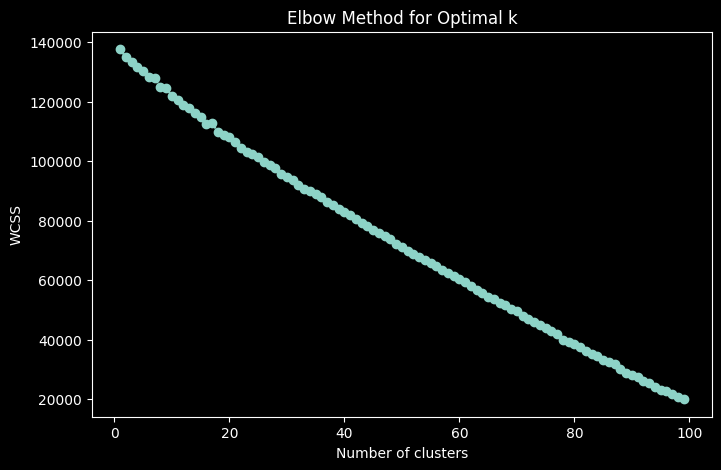

         SALE_COUNT   WEEKDAY  AIRLINENAME_AERO K AIRLINES  \
Cluster                                                      
0          1.056338  3.295775                          0.0   
1          1.666667  4.000000                          0.0   
2          1.133333  2.800000                          0.0   
3          1.486486  3.702703                          0.0   
4          1.057143  2.828571                          0.0   
...             ...       ...                          ...   
67         1.666667  3.666667                          0.0   
68         1.000000  4.000000                          0.0   
69         1.000000  0.000000                          0.0   
70         1.000000  3.400000                          0.0   
71         1.000000  3.200000                          0.0   

         AIRLINENAME_LOT폴란드 항공  AIRLINENAME_가루다인도네시아  AIRLINENAME_그레이터베이항공  \
Cluster                                                                      
0                          0.0       

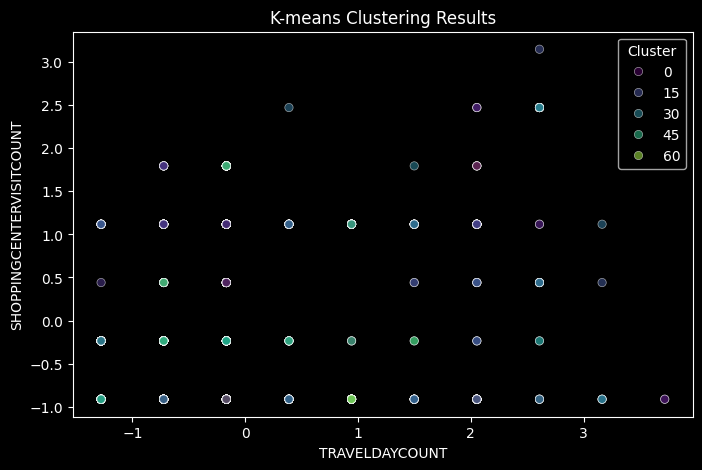

In [205]:
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans


# 특성 스케일링 (StandardScaler를 사용하여 데이터의 범위를 조정)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# 최적의 클러스터 수를 찾기 위해 엘보우 방법을 사용
wcss = []  # 클러스터 내 제곱합 (Within-cluster sum of squares)

for i in range(1, 100):
    kmeans = KMeans(
        n_clusters=i, init="k-means++", max_iter=300, n_init=10, random_state=36
    )
    kmeans.fit(X_scaled)
    wcss.append(kmeans.inertia_)

# 엘보우 방법 그래프 시각화
plt.figure(figsize=(8, 5))
plt.plot(range(1, 100), wcss, marker="o", linestyle="--")
plt.title("Elbow Method for Optimal k")
plt.xlabel("Number of clusters")
plt.ylabel("WCSS")
plt.show()

# 클러스터 수 선택 (예: 3개)
optimal_clusters = 72
kmeans = KMeans(
    n_clusters=optimal_clusters,
    init="k-means++",
    max_iter=300,
    n_init=10,
    random_state=36,
)
kmeans.fit(X_scaled)
labels = kmeans.labels_

# 클러스터 결과를 원래 데이터프레임에 추가
encoded_df["Cluster"] = labels


# 클러스터별 데이터 통계 요약
numeric_columns = encoded_df.select_dtypes(include=["number"]).columns
cluster_summary = encoded_df.groupby("Cluster")[numeric_columns].mean()
print(cluster_summary)


# 클러스터 결과 시각화 (예: 첫 두 개의 특성만 사용)
plt.figure(figsize=(8, 5))
sns.scatterplot(
    x=X_scaled[:, 0], y=X_scaled[:, 1], hue=labels, palette="viridis", alpha=0.6
)
plt.title("K-means Clustering Results")
plt.xlabel(features[0])
plt.ylabel(features[1])
plt.legend(title="Cluster")
plt.show()

In [266]:
!pip install -qU tensorflow-intel

114    8
103    8
119    8
112    8
100    8
102    8
109    8
106    8
893    6
99     6
Name: SALE_COUNT, dtype: int64
Original X_train_scaled shape: (744, 130)
Augmented X_train_combined shape: (1488, 130)
Original y_train shape: (744,)
Augmented y_train_combined shape: (1488,)
X_train_combined shape: (1488, 130)
y_train_combined shape: (1488,)
X_test_scaled shape: (331, 130)
y_test shape: (331,)

Final Data Integrity Checks:
Any NaNs in X_train_combined: False
Any Infs in X_train_combined: False
Any NaNs in y_train_combined: False
Any Infs in y_train_combined: False

Data Types:
X_train_combined dtype: float32
y_train_combined dtype: float32
X_test_scaled dtype: float32
y_test dtype: float32

y_train_combined shape before reshape: (1488,)
y_train_combined shape after reshape: (1488,)
y_test shape after reshape: (331,)

After conversion and reshaping:
X_train_combined dtype: float32
y_train_combined dtype: float32
X_test_scaled dtype: float32
y_test dtype: float32


[I 2024-10-21 14:28:20,912] A new study created in RDB with name: test
C:\Users\douly\AppData\Local\Temp\ipykernel_4344\1098012965.py:226: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-4, 1e-3)
C:\Users\douly\AppData\Local\Temp\ipykernel_4344\1098012965.py:227: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  dropout_rate = trial.suggest_uniform("dropout_rate", 0.01, 0.3)


10/10 [==============================] - 0s 845us/step


c:\Users\douly\AppData\Local\pypoetry\Cache\virtualenvs\biztour-2MXTw1DY-py3.11\Lib\site-packages\optuna\trial\_trial.py:497: UserWarning: The reported value is ignored because this `step` 0 is already reported.
  warnings.warn(
c:\Users\douly\AppData\Local\pypoetry\Cache\virtualenvs\biztour-2MXTw1DY-py3.11\Lib\site-packages\optuna\trial\_trial.py:497: UserWarning: The reported value is ignored because this `step` 1 is already reported.
  warnings.warn(
c:\Users\douly\AppData\Local\pypoetry\Cache\virtualenvs\biztour-2MXTw1DY-py3.11\Lib\site-packages\optuna\trial\_trial.py:497: UserWarning: The reported value is ignored because this `step` 2 is already reported.
  warnings.warn(
c:\Users\douly\AppData\Local\pypoetry\Cache\virtualenvs\biztour-2MXTw1DY-py3.11\Lib\site-packages\optuna\trial\_trial.py:497: UserWarning: The reported value is ignored because this `step` 3 is already reported.
  warnings.warn(
c:\Users\douly\AppData\Local\pypoetry\Cache\virtualenvs\biztour-2MXTw1DY-py3.11\Lib\

10/10 [==============================] - 0s 975us/step


c:\Users\douly\AppData\Local\pypoetry\Cache\virtualenvs\biztour-2MXTw1DY-py3.11\Lib\site-packages\optuna\trial\_trial.py:497: UserWarning: The reported value is ignored because this `step` 99 is already reported.
  warnings.warn(
c:\Users\douly\AppData\Local\pypoetry\Cache\virtualenvs\biztour-2MXTw1DY-py3.11\Lib\site-packages\optuna\trial\_trial.py:497: UserWarning: The reported value is ignored because this `step` 0 is already reported.
  warnings.warn(
c:\Users\douly\AppData\Local\pypoetry\Cache\virtualenvs\biztour-2MXTw1DY-py3.11\Lib\site-packages\optuna\trial\_trial.py:497: UserWarning: The reported value is ignored because this `step` 1 is already reported.
  warnings.warn(
c:\Users\douly\AppData\Local\pypoetry\Cache\virtualenvs\biztour-2MXTw1DY-py3.11\Lib\site-packages\optuna\trial\_trial.py:497: UserWarning: The reported value is ignored because this `step` 2 is already reported.
  warnings.warn(
c:\Users\douly\AppData\Local\pypoetry\Cache\virtualenvs\biztour-2MXTw1DY-py3.11\Lib

10/10 [==============================] - 0s 1ms/step


c:\Users\douly\AppData\Local\pypoetry\Cache\virtualenvs\biztour-2MXTw1DY-py3.11\Lib\site-packages\optuna\trial\_trial.py:497: UserWarning: The reported value is ignored because this `step` 99 is already reported.
  warnings.warn(
c:\Users\douly\AppData\Local\pypoetry\Cache\virtualenvs\biztour-2MXTw1DY-py3.11\Lib\site-packages\optuna\trial\_trial.py:497: UserWarning: The reported value is ignored because this `step` 0 is already reported.
  warnings.warn(
c:\Users\douly\AppData\Local\pypoetry\Cache\virtualenvs\biztour-2MXTw1DY-py3.11\Lib\site-packages\optuna\trial\_trial.py:497: UserWarning: The reported value is ignored because this `step` 1 is already reported.
  warnings.warn(
c:\Users\douly\AppData\Local\pypoetry\Cache\virtualenvs\biztour-2MXTw1DY-py3.11\Lib\site-packages\optuna\trial\_trial.py:497: UserWarning: The reported value is ignored because this `step` 2 is already reported.
  warnings.warn(
c:\Users\douly\AppData\Local\pypoetry\Cache\virtualenvs\biztour-2MXTw1DY-py3.11\Lib

10/10 [==============================] - 0s 1ms/step


c:\Users\douly\AppData\Local\pypoetry\Cache\virtualenvs\biztour-2MXTw1DY-py3.11\Lib\site-packages\optuna\trial\_trial.py:497: UserWarning: The reported value is ignored because this `step` 99 is already reported.
  warnings.warn(
c:\Users\douly\AppData\Local\pypoetry\Cache\virtualenvs\biztour-2MXTw1DY-py3.11\Lib\site-packages\optuna\trial\_trial.py:497: UserWarning: The reported value is ignored because this `step` 0 is already reported.
  warnings.warn(
c:\Users\douly\AppData\Local\pypoetry\Cache\virtualenvs\biztour-2MXTw1DY-py3.11\Lib\site-packages\optuna\trial\_trial.py:497: UserWarning: The reported value is ignored because this `step` 1 is already reported.
  warnings.warn(
c:\Users\douly\AppData\Local\pypoetry\Cache\virtualenvs\biztour-2MXTw1DY-py3.11\Lib\site-packages\optuna\trial\_trial.py:497: UserWarning: The reported value is ignored because this `step` 2 is already reported.
  warnings.warn(
c:\Users\douly\AppData\Local\pypoetry\Cache\virtualenvs\biztour-2MXTw1DY-py3.11\Lib

10/10 [==============================] - 0s 1ms/step


[I 2024-10-21 14:29:23,255] Trial 0 finished with value: 0.2621660828590393 and parameters: {'learning_rate': 0.00037306513999673795, 'dropout_rate': 0.035546388341301034, 'n_layers': 3, 'n_units': 118, 'batch_size': 32, 'epochs': 100}. Best is trial 0 with value: 0.2621660828590393.
C:\Users\douly\AppData\Local\Temp\ipykernel_4344\1098012965.py:226: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-4, 1e-3)
C:\Users\douly\AppData\Local\Temp\ipykernel_4344\1098012965.py:227: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  dropout_rate = trial.suggest_uniform("dropout_rate", 0.01, 0.3)


10/10 [==============================] - 0s 926us/step


c:\Users\douly\AppData\Local\pypoetry\Cache\virtualenvs\biztour-2MXTw1DY-py3.11\Lib\site-packages\optuna\trial\_trial.py:497: UserWarning: The reported value is ignored because this `step` 0 is already reported.
  warnings.warn(
c:\Users\douly\AppData\Local\pypoetry\Cache\virtualenvs\biztour-2MXTw1DY-py3.11\Lib\site-packages\optuna\trial\_trial.py:497: UserWarning: The reported value is ignored because this `step` 1 is already reported.
  warnings.warn(
c:\Users\douly\AppData\Local\pypoetry\Cache\virtualenvs\biztour-2MXTw1DY-py3.11\Lib\site-packages\optuna\trial\_trial.py:497: UserWarning: The reported value is ignored because this `step` 2 is already reported.
  warnings.warn(
c:\Users\douly\AppData\Local\pypoetry\Cache\virtualenvs\biztour-2MXTw1DY-py3.11\Lib\site-packages\optuna\trial\_trial.py:497: UserWarning: The reported value is ignored because this `step` 3 is already reported.
  warnings.warn(
c:\Users\douly\AppData\Local\pypoetry\Cache\virtualenvs\biztour-2MXTw1DY-py3.11\Lib\

10/10 [==============================] - 0s 949us/step


c:\Users\douly\AppData\Local\pypoetry\Cache\virtualenvs\biztour-2MXTw1DY-py3.11\Lib\site-packages\optuna\trial\_trial.py:497: UserWarning: The reported value is ignored because this `step` 0 is already reported.
  warnings.warn(
c:\Users\douly\AppData\Local\pypoetry\Cache\virtualenvs\biztour-2MXTw1DY-py3.11\Lib\site-packages\optuna\trial\_trial.py:497: UserWarning: The reported value is ignored because this `step` 1 is already reported.
  warnings.warn(
c:\Users\douly\AppData\Local\pypoetry\Cache\virtualenvs\biztour-2MXTw1DY-py3.11\Lib\site-packages\optuna\trial\_trial.py:497: UserWarning: The reported value is ignored because this `step` 2 is already reported.
  warnings.warn(
c:\Users\douly\AppData\Local\pypoetry\Cache\virtualenvs\biztour-2MXTw1DY-py3.11\Lib\site-packages\optuna\trial\_trial.py:497: UserWarning: The reported value is ignored because this `step` 3 is already reported.
  warnings.warn(
c:\Users\douly\AppData\Local\pypoetry\Cache\virtualenvs\biztour-2MXTw1DY-py3.11\Lib\

 1/10 [==>...........................] - ETA: 0s

c:\Users\douly\AppData\Local\pypoetry\Cache\virtualenvs\biztour-2MXTw1DY-py3.11\Lib\site-packages\optuna\trial\_trial.py:497: UserWarning: The reported value is ignored because this `step` 78 is already reported.
  warnings.warn(
c:\Users\douly\AppData\Local\pypoetry\Cache\virtualenvs\biztour-2MXTw1DY-py3.11\Lib\site-packages\optuna\trial\_trial.py:497: UserWarning: The reported value is ignored because this `step` 79 is already reported.
  warnings.warn(


10/10 [==============================] - 0s 841us/step


c:\Users\douly\AppData\Local\pypoetry\Cache\virtualenvs\biztour-2MXTw1DY-py3.11\Lib\site-packages\optuna\trial\_trial.py:497: UserWarning: The reported value is ignored because this `step` 0 is already reported.
  warnings.warn(
c:\Users\douly\AppData\Local\pypoetry\Cache\virtualenvs\biztour-2MXTw1DY-py3.11\Lib\site-packages\optuna\trial\_trial.py:497: UserWarning: The reported value is ignored because this `step` 1 is already reported.
  warnings.warn(
c:\Users\douly\AppData\Local\pypoetry\Cache\virtualenvs\biztour-2MXTw1DY-py3.11\Lib\site-packages\optuna\trial\_trial.py:497: UserWarning: The reported value is ignored because this `step` 2 is already reported.
  warnings.warn(
c:\Users\douly\AppData\Local\pypoetry\Cache\virtualenvs\biztour-2MXTw1DY-py3.11\Lib\site-packages\optuna\trial\_trial.py:497: UserWarning: The reported value is ignored because this `step` 3 is already reported.
  warnings.warn(
c:\Users\douly\AppData\Local\pypoetry\Cache\virtualenvs\biztour-2MXTw1DY-py3.11\Lib\

10/10 [==============================] - 0s 903us/step


c:\Users\douly\AppData\Local\pypoetry\Cache\virtualenvs\biztour-2MXTw1DY-py3.11\Lib\site-packages\optuna\trial\_trial.py:497: UserWarning: The reported value is ignored because this `step` 0 is already reported.
  warnings.warn(
c:\Users\douly\AppData\Local\pypoetry\Cache\virtualenvs\biztour-2MXTw1DY-py3.11\Lib\site-packages\optuna\trial\_trial.py:497: UserWarning: The reported value is ignored because this `step` 1 is already reported.
  warnings.warn(
c:\Users\douly\AppData\Local\pypoetry\Cache\virtualenvs\biztour-2MXTw1DY-py3.11\Lib\site-packages\optuna\trial\_trial.py:497: UserWarning: The reported value is ignored because this `step` 2 is already reported.
  warnings.warn(
c:\Users\douly\AppData\Local\pypoetry\Cache\virtualenvs\biztour-2MXTw1DY-py3.11\Lib\site-packages\optuna\trial\_trial.py:497: UserWarning: The reported value is ignored because this `step` 3 is already reported.
  warnings.warn(
c:\Users\douly\AppData\Local\pypoetry\Cache\virtualenvs\biztour-2MXTw1DY-py3.11\Lib\

 1/10 [==>...........................] - ETA: 0s

c:\Users\douly\AppData\Local\pypoetry\Cache\virtualenvs\biztour-2MXTw1DY-py3.11\Lib\site-packages\optuna\trial\_trial.py:497: UserWarning: The reported value is ignored because this `step` 78 is already reported.
  warnings.warn(
c:\Users\douly\AppData\Local\pypoetry\Cache\virtualenvs\biztour-2MXTw1DY-py3.11\Lib\site-packages\optuna\trial\_trial.py:497: UserWarning: The reported value is ignored because this `step` 79 is already reported.
  warnings.warn(


10/10 [==============================] - 0s 933us/step


[I 2024-10-21 14:30:05,450] Trial 1 finished with value: 0.30803006887435913 and parameters: {'learning_rate': 0.00020290933685018276, 'dropout_rate': 0.09371926395422743, 'n_layers': 3, 'n_units': 69, 'batch_size': 32, 'epochs': 80}. Best is trial 0 with value: 0.2621660828590393.
C:\Users\douly\AppData\Local\Temp\ipykernel_4344\1098012965.py:226: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-4, 1e-3)
C:\Users\douly\AppData\Local\Temp\ipykernel_4344\1098012965.py:227: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  dropout_rate = trial.suggest_uniform("dropout_rate", 0.01, 0.3)


10/10 [==============================] - 0s 1ms/step


c:\Users\douly\AppData\Local\pypoetry\Cache\virtualenvs\biztour-2MXTw1DY-py3.11\Lib\site-packages\optuna\trial\_trial.py:497: UserWarning: The reported value is ignored because this `step` 0 is already reported.
  warnings.warn(
c:\Users\douly\AppData\Local\pypoetry\Cache\virtualenvs\biztour-2MXTw1DY-py3.11\Lib\site-packages\optuna\trial\_trial.py:497: UserWarning: The reported value is ignored because this `step` 1 is already reported.
  warnings.warn(
c:\Users\douly\AppData\Local\pypoetry\Cache\virtualenvs\biztour-2MXTw1DY-py3.11\Lib\site-packages\optuna\trial\_trial.py:497: UserWarning: The reported value is ignored because this `step` 2 is already reported.
  warnings.warn(
c:\Users\douly\AppData\Local\pypoetry\Cache\virtualenvs\biztour-2MXTw1DY-py3.11\Lib\site-packages\optuna\trial\_trial.py:497: UserWarning: The reported value is ignored because this `step` 3 is already reported.
  warnings.warn(
c:\Users\douly\AppData\Local\pypoetry\Cache\virtualenvs\biztour-2MXTw1DY-py3.11\Lib\

10/10 [==============================] - 0s 1ms/step


c:\Users\douly\AppData\Local\pypoetry\Cache\virtualenvs\biztour-2MXTw1DY-py3.11\Lib\site-packages\optuna\trial\_trial.py:497: UserWarning: The reported value is ignored because this `step` 0 is already reported.
  warnings.warn(
c:\Users\douly\AppData\Local\pypoetry\Cache\virtualenvs\biztour-2MXTw1DY-py3.11\Lib\site-packages\optuna\trial\_trial.py:497: UserWarning: The reported value is ignored because this `step` 1 is already reported.
  warnings.warn(
c:\Users\douly\AppData\Local\pypoetry\Cache\virtualenvs\biztour-2MXTw1DY-py3.11\Lib\site-packages\optuna\trial\_trial.py:497: UserWarning: The reported value is ignored because this `step` 2 is already reported.
  warnings.warn(
c:\Users\douly\AppData\Local\pypoetry\Cache\virtualenvs\biztour-2MXTw1DY-py3.11\Lib\site-packages\optuna\trial\_trial.py:497: UserWarning: The reported value is ignored because this `step` 3 is already reported.
  warnings.warn(
c:\Users\douly\AppData\Local\pypoetry\Cache\virtualenvs\biztour-2MXTw1DY-py3.11\Lib\

10/10 [==============================] - 0s 1ms/step


c:\Users\douly\AppData\Local\pypoetry\Cache\virtualenvs\biztour-2MXTw1DY-py3.11\Lib\site-packages\optuna\trial\_trial.py:497: UserWarning: The reported value is ignored because this `step` 119 is already reported.
  warnings.warn(
c:\Users\douly\AppData\Local\pypoetry\Cache\virtualenvs\biztour-2MXTw1DY-py3.11\Lib\site-packages\optuna\trial\_trial.py:497: UserWarning: The reported value is ignored because this `step` 0 is already reported.
  warnings.warn(
c:\Users\douly\AppData\Local\pypoetry\Cache\virtualenvs\biztour-2MXTw1DY-py3.11\Lib\site-packages\optuna\trial\_trial.py:497: UserWarning: The reported value is ignored because this `step` 1 is already reported.
  warnings.warn(
c:\Users\douly\AppData\Local\pypoetry\Cache\virtualenvs\biztour-2MXTw1DY-py3.11\Lib\site-packages\optuna\trial\_trial.py:497: UserWarning: The reported value is ignored because this `step` 2 is already reported.
  warnings.warn(
c:\Users\douly\AppData\Local\pypoetry\Cache\virtualenvs\biztour-2MXTw1DY-py3.11\Li

10/10 [==============================] - 0s 1ms/step


c:\Users\douly\AppData\Local\pypoetry\Cache\virtualenvs\biztour-2MXTw1DY-py3.11\Lib\site-packages\optuna\trial\_trial.py:497: UserWarning: The reported value is ignored because this `step` 119 is already reported.
  warnings.warn(
c:\Users\douly\AppData\Local\pypoetry\Cache\virtualenvs\biztour-2MXTw1DY-py3.11\Lib\site-packages\optuna\trial\_trial.py:497: UserWarning: The reported value is ignored because this `step` 0 is already reported.
  warnings.warn(
c:\Users\douly\AppData\Local\pypoetry\Cache\virtualenvs\biztour-2MXTw1DY-py3.11\Lib\site-packages\optuna\trial\_trial.py:497: UserWarning: The reported value is ignored because this `step` 1 is already reported.
  warnings.warn(
c:\Users\douly\AppData\Local\pypoetry\Cache\virtualenvs\biztour-2MXTw1DY-py3.11\Lib\site-packages\optuna\trial\_trial.py:497: UserWarning: The reported value is ignored because this `step` 2 is already reported.
  warnings.warn(
c:\Users\douly\AppData\Local\pypoetry\Cache\virtualenvs\biztour-2MXTw1DY-py3.11\Li

10/10 [==============================] - 0s 1ms/step


c:\Users\douly\AppData\Local\pypoetry\Cache\virtualenvs\biztour-2MXTw1DY-py3.11\Lib\site-packages\optuna\trial\_trial.py:497: UserWarning: The reported value is ignored because this `step` 119 is already reported.
  warnings.warn(
[I 2024-10-21 14:31:59,913] Trial 2 finished with value: 0.25841858983039856 and parameters: {'learning_rate': 0.0005958497815414208, 'dropout_rate': 0.23224418284649992, 'n_layers': 4, 'n_units': 107, 'batch_size': 16, 'epochs': 120}. Best is trial 2 with value: 0.25841858983039856.
C:\Users\douly\AppData\Local\Temp\ipykernel_4344\1098012965.py:226: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-4, 1e-3)
C:\Users\douly\AppData\Local\Temp\ipykernel_4344\1098012965.py:227: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feat

10/10 [==============================] - 0s 1ms/step


c:\Users\douly\AppData\Local\pypoetry\Cache\virtualenvs\biztour-2MXTw1DY-py3.11\Lib\site-packages\optuna\trial\_trial.py:497: UserWarning: The reported value is ignored because this `step` 0 is already reported.
  warnings.warn(
c:\Users\douly\AppData\Local\pypoetry\Cache\virtualenvs\biztour-2MXTw1DY-py3.11\Lib\site-packages\optuna\trial\_trial.py:497: UserWarning: The reported value is ignored because this `step` 1 is already reported.
  warnings.warn(
c:\Users\douly\AppData\Local\pypoetry\Cache\virtualenvs\biztour-2MXTw1DY-py3.11\Lib\site-packages\optuna\trial\_trial.py:497: UserWarning: The reported value is ignored because this `step` 2 is already reported.
  warnings.warn(
c:\Users\douly\AppData\Local\pypoetry\Cache\virtualenvs\biztour-2MXTw1DY-py3.11\Lib\site-packages\optuna\trial\_trial.py:497: UserWarning: The reported value is ignored because this `step` 3 is already reported.
  warnings.warn(
c:\Users\douly\AppData\Local\pypoetry\Cache\virtualenvs\biztour-2MXTw1DY-py3.11\Lib\

10/10 [==============================] - 0s 1ms/step


c:\Users\douly\AppData\Local\pypoetry\Cache\virtualenvs\biztour-2MXTw1DY-py3.11\Lib\site-packages\optuna\trial\_trial.py:497: UserWarning: The reported value is ignored because this `step` 0 is already reported.
  warnings.warn(
c:\Users\douly\AppData\Local\pypoetry\Cache\virtualenvs\biztour-2MXTw1DY-py3.11\Lib\site-packages\optuna\trial\_trial.py:497: UserWarning: The reported value is ignored because this `step` 1 is already reported.
  warnings.warn(
c:\Users\douly\AppData\Local\pypoetry\Cache\virtualenvs\biztour-2MXTw1DY-py3.11\Lib\site-packages\optuna\trial\_trial.py:497: UserWarning: The reported value is ignored because this `step` 2 is already reported.
  warnings.warn(
c:\Users\douly\AppData\Local\pypoetry\Cache\virtualenvs\biztour-2MXTw1DY-py3.11\Lib\site-packages\optuna\trial\_trial.py:497: UserWarning: The reported value is ignored because this `step` 3 is already reported.
  warnings.warn(
c:\Users\douly\AppData\Local\pypoetry\Cache\virtualenvs\biztour-2MXTw1DY-py3.11\Lib\

10/10 [==============================] - 0s 1ms/step


c:\Users\douly\AppData\Local\pypoetry\Cache\virtualenvs\biztour-2MXTw1DY-py3.11\Lib\site-packages\optuna\trial\_trial.py:497: UserWarning: The reported value is ignored because this `step` 0 is already reported.
  warnings.warn(
c:\Users\douly\AppData\Local\pypoetry\Cache\virtualenvs\biztour-2MXTw1DY-py3.11\Lib\site-packages\optuna\trial\_trial.py:497: UserWarning: The reported value is ignored because this `step` 1 is already reported.
  warnings.warn(
c:\Users\douly\AppData\Local\pypoetry\Cache\virtualenvs\biztour-2MXTw1DY-py3.11\Lib\site-packages\optuna\trial\_trial.py:497: UserWarning: The reported value is ignored because this `step` 2 is already reported.
  warnings.warn(
c:\Users\douly\AppData\Local\pypoetry\Cache\virtualenvs\biztour-2MXTw1DY-py3.11\Lib\site-packages\optuna\trial\_trial.py:497: UserWarning: The reported value is ignored because this `step` 3 is already reported.
  warnings.warn(
c:\Users\douly\AppData\Local\pypoetry\Cache\virtualenvs\biztour-2MXTw1DY-py3.11\Lib\

10/10 [==============================] - 0s 1ms/step


c:\Users\douly\AppData\Local\pypoetry\Cache\virtualenvs\biztour-2MXTw1DY-py3.11\Lib\site-packages\optuna\trial\_trial.py:497: UserWarning: The reported value is ignored because this `step` 0 is already reported.
  warnings.warn(
c:\Users\douly\AppData\Local\pypoetry\Cache\virtualenvs\biztour-2MXTw1DY-py3.11\Lib\site-packages\optuna\trial\_trial.py:497: UserWarning: The reported value is ignored because this `step` 1 is already reported.
  warnings.warn(
c:\Users\douly\AppData\Local\pypoetry\Cache\virtualenvs\biztour-2MXTw1DY-py3.11\Lib\site-packages\optuna\trial\_trial.py:497: UserWarning: The reported value is ignored because this `step` 2 is already reported.
  warnings.warn(
c:\Users\douly\AppData\Local\pypoetry\Cache\virtualenvs\biztour-2MXTw1DY-py3.11\Lib\site-packages\optuna\trial\_trial.py:497: UserWarning: The reported value is ignored because this `step` 3 is already reported.
  warnings.warn(
c:\Users\douly\AppData\Local\pypoetry\Cache\virtualenvs\biztour-2MXTw1DY-py3.11\Lib\

10/10 [==============================] - 0s 988us/step


[I 2024-10-21 14:32:45,784] Trial 3 finished with value: 0.2755454182624817 and parameters: {'learning_rate': 0.0006686351164475788, 'dropout_rate': 0.14715611959138336, 'n_layers': 3, 'n_units': 66, 'batch_size': 32, 'epochs': 80}. Best is trial 2 with value: 0.25841858983039856.
C:\Users\douly\AppData\Local\Temp\ipykernel_4344\1098012965.py:226: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-4, 1e-3)
C:\Users\douly\AppData\Local\Temp\ipykernel_4344\1098012965.py:227: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  dropout_rate = trial.suggest_uniform("dropout_rate", 0.01, 0.3)


10/10 [==============================] - 0s 1ms/step


c:\Users\douly\AppData\Local\pypoetry\Cache\virtualenvs\biztour-2MXTw1DY-py3.11\Lib\site-packages\optuna\trial\_trial.py:497: UserWarning: The reported value is ignored because this `step` 0 is already reported.
  warnings.warn(
c:\Users\douly\AppData\Local\pypoetry\Cache\virtualenvs\biztour-2MXTw1DY-py3.11\Lib\site-packages\optuna\trial\_trial.py:497: UserWarning: The reported value is ignored because this `step` 1 is already reported.
  warnings.warn(
c:\Users\douly\AppData\Local\pypoetry\Cache\virtualenvs\biztour-2MXTw1DY-py3.11\Lib\site-packages\optuna\trial\_trial.py:497: UserWarning: The reported value is ignored because this `step` 2 is already reported.
  warnings.warn(
c:\Users\douly\AppData\Local\pypoetry\Cache\virtualenvs\biztour-2MXTw1DY-py3.11\Lib\site-packages\optuna\trial\_trial.py:497: UserWarning: The reported value is ignored because this `step` 3 is already reported.
  warnings.warn(
c:\Users\douly\AppData\Local\pypoetry\Cache\virtualenvs\biztour-2MXTw1DY-py3.11\Lib\

10/10 [==============================] - 0s 1ms/step


c:\Users\douly\AppData\Local\pypoetry\Cache\virtualenvs\biztour-2MXTw1DY-py3.11\Lib\site-packages\optuna\trial\_trial.py:497: UserWarning: The reported value is ignored because this `step` 79 is already reported.
  warnings.warn(
c:\Users\douly\AppData\Local\pypoetry\Cache\virtualenvs\biztour-2MXTw1DY-py3.11\Lib\site-packages\optuna\trial\_trial.py:497: UserWarning: The reported value is ignored because this `step` 0 is already reported.
  warnings.warn(
c:\Users\douly\AppData\Local\pypoetry\Cache\virtualenvs\biztour-2MXTw1DY-py3.11\Lib\site-packages\optuna\trial\_trial.py:497: UserWarning: The reported value is ignored because this `step` 1 is already reported.
  warnings.warn(
c:\Users\douly\AppData\Local\pypoetry\Cache\virtualenvs\biztour-2MXTw1DY-py3.11\Lib\site-packages\optuna\trial\_trial.py:497: UserWarning: The reported value is ignored because this `step` 2 is already reported.
  warnings.warn(
c:\Users\douly\AppData\Local\pypoetry\Cache\virtualenvs\biztour-2MXTw1DY-py3.11\Lib

10/10 [==============================] - 0s 975us/step


c:\Users\douly\AppData\Local\pypoetry\Cache\virtualenvs\biztour-2MXTw1DY-py3.11\Lib\site-packages\optuna\trial\_trial.py:497: UserWarning: The reported value is ignored because this `step` 79 is already reported.
  warnings.warn(
c:\Users\douly\AppData\Local\pypoetry\Cache\virtualenvs\biztour-2MXTw1DY-py3.11\Lib\site-packages\optuna\trial\_trial.py:497: UserWarning: The reported value is ignored because this `step` 0 is already reported.
  warnings.warn(
c:\Users\douly\AppData\Local\pypoetry\Cache\virtualenvs\biztour-2MXTw1DY-py3.11\Lib\site-packages\optuna\trial\_trial.py:497: UserWarning: The reported value is ignored because this `step` 1 is already reported.
  warnings.warn(
c:\Users\douly\AppData\Local\pypoetry\Cache\virtualenvs\biztour-2MXTw1DY-py3.11\Lib\site-packages\optuna\trial\_trial.py:497: UserWarning: The reported value is ignored because this `step` 2 is already reported.
  warnings.warn(
c:\Users\douly\AppData\Local\pypoetry\Cache\virtualenvs\biztour-2MXTw1DY-py3.11\Lib

10/10 [==============================] - 0s 1ms/step


c:\Users\douly\AppData\Local\pypoetry\Cache\virtualenvs\biztour-2MXTw1DY-py3.11\Lib\site-packages\optuna\trial\_trial.py:497: UserWarning: The reported value is ignored because this `step` 79 is already reported.
  warnings.warn(
c:\Users\douly\AppData\Local\pypoetry\Cache\virtualenvs\biztour-2MXTw1DY-py3.11\Lib\site-packages\optuna\trial\_trial.py:497: UserWarning: The reported value is ignored because this `step` 0 is already reported.
  warnings.warn(
c:\Users\douly\AppData\Local\pypoetry\Cache\virtualenvs\biztour-2MXTw1DY-py3.11\Lib\site-packages\optuna\trial\_trial.py:497: UserWarning: The reported value is ignored because this `step` 1 is already reported.
  warnings.warn(
c:\Users\douly\AppData\Local\pypoetry\Cache\virtualenvs\biztour-2MXTw1DY-py3.11\Lib\site-packages\optuna\trial\_trial.py:497: UserWarning: The reported value is ignored because this `step` 2 is already reported.
  warnings.warn(
c:\Users\douly\AppData\Local\pypoetry\Cache\virtualenvs\biztour-2MXTw1DY-py3.11\Lib

10/10 [==============================] - 0s 1ms/step


c:\Users\douly\AppData\Local\pypoetry\Cache\virtualenvs\biztour-2MXTw1DY-py3.11\Lib\site-packages\optuna\trial\_trial.py:497: UserWarning: The reported value is ignored because this `step` 79 is already reported.
  warnings.warn(
[I 2024-10-21 14:34:34,884] Trial 4 finished with value: 0.25645336508750916 and parameters: {'learning_rate': 0.0004156525353525387, 'dropout_rate': 0.19960285180513684, 'n_layers': 4, 'n_units': 87, 'batch_size': 8, 'epochs': 80}. Best is trial 4 with value: 0.25645336508750916.
C:\Users\douly\AppData\Local\Temp\ipykernel_4344\1098012965.py:226: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-4, 1e-3)
C:\Users\douly\AppData\Local\Temp\ipykernel_4344\1098012965.py:227: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature 

10/10 [==============================] - 0s 1ms/step


c:\Users\douly\AppData\Local\pypoetry\Cache\virtualenvs\biztour-2MXTw1DY-py3.11\Lib\site-packages\optuna\trial\_trial.py:497: UserWarning: The reported value is ignored because this `step` 0 is already reported.
  warnings.warn(
c:\Users\douly\AppData\Local\pypoetry\Cache\virtualenvs\biztour-2MXTw1DY-py3.11\Lib\site-packages\optuna\trial\_trial.py:497: UserWarning: The reported value is ignored because this `step` 1 is already reported.
  warnings.warn(
c:\Users\douly\AppData\Local\pypoetry\Cache\virtualenvs\biztour-2MXTw1DY-py3.11\Lib\site-packages\optuna\trial\_trial.py:497: UserWarning: The reported value is ignored because this `step` 2 is already reported.
  warnings.warn(
c:\Users\douly\AppData\Local\pypoetry\Cache\virtualenvs\biztour-2MXTw1DY-py3.11\Lib\site-packages\optuna\trial\_trial.py:497: UserWarning: The reported value is ignored because this `step` 3 is already reported.
  warnings.warn(
c:\Users\douly\AppData\Local\pypoetry\Cache\virtualenvs\biztour-2MXTw1DY-py3.11\Lib\

10/10 [==============================] - 0s 893us/step


c:\Users\douly\AppData\Local\pypoetry\Cache\virtualenvs\biztour-2MXTw1DY-py3.11\Lib\site-packages\optuna\trial\_trial.py:497: UserWarning: The reported value is ignored because this `step` 79 is already reported.
  warnings.warn(
c:\Users\douly\AppData\Local\pypoetry\Cache\virtualenvs\biztour-2MXTw1DY-py3.11\Lib\site-packages\optuna\trial\_trial.py:497: UserWarning: The reported value is ignored because this `step` 0 is already reported.
  warnings.warn(
c:\Users\douly\AppData\Local\pypoetry\Cache\virtualenvs\biztour-2MXTw1DY-py3.11\Lib\site-packages\optuna\trial\_trial.py:497: UserWarning: The reported value is ignored because this `step` 1 is already reported.
  warnings.warn(
c:\Users\douly\AppData\Local\pypoetry\Cache\virtualenvs\biztour-2MXTw1DY-py3.11\Lib\site-packages\optuna\trial\_trial.py:497: UserWarning: The reported value is ignored because this `step` 2 is already reported.
  warnings.warn(
c:\Users\douly\AppData\Local\pypoetry\Cache\virtualenvs\biztour-2MXTw1DY-py3.11\Lib

10/10 [==============================] - 0s 1ms/step


c:\Users\douly\AppData\Local\pypoetry\Cache\virtualenvs\biztour-2MXTw1DY-py3.11\Lib\site-packages\optuna\trial\_trial.py:497: UserWarning: The reported value is ignored because this `step` 79 is already reported.
  warnings.warn(
c:\Users\douly\AppData\Local\pypoetry\Cache\virtualenvs\biztour-2MXTw1DY-py3.11\Lib\site-packages\optuna\trial\_trial.py:497: UserWarning: The reported value is ignored because this `step` 0 is already reported.
  warnings.warn(
c:\Users\douly\AppData\Local\pypoetry\Cache\virtualenvs\biztour-2MXTw1DY-py3.11\Lib\site-packages\optuna\trial\_trial.py:497: UserWarning: The reported value is ignored because this `step` 1 is already reported.
  warnings.warn(
c:\Users\douly\AppData\Local\pypoetry\Cache\virtualenvs\biztour-2MXTw1DY-py3.11\Lib\site-packages\optuna\trial\_trial.py:497: UserWarning: The reported value is ignored because this `step` 2 is already reported.
  warnings.warn(
c:\Users\douly\AppData\Local\pypoetry\Cache\virtualenvs\biztour-2MXTw1DY-py3.11\Lib

10/10 [==============================] - 0s 1ms/step


c:\Users\douly\AppData\Local\pypoetry\Cache\virtualenvs\biztour-2MXTw1DY-py3.11\Lib\site-packages\optuna\trial\_trial.py:497: UserWarning: The reported value is ignored because this `step` 79 is already reported.
  warnings.warn(
c:\Users\douly\AppData\Local\pypoetry\Cache\virtualenvs\biztour-2MXTw1DY-py3.11\Lib\site-packages\optuna\trial\_trial.py:497: UserWarning: The reported value is ignored because this `step` 0 is already reported.
  warnings.warn(
c:\Users\douly\AppData\Local\pypoetry\Cache\virtualenvs\biztour-2MXTw1DY-py3.11\Lib\site-packages\optuna\trial\_trial.py:497: UserWarning: The reported value is ignored because this `step` 1 is already reported.
  warnings.warn(
c:\Users\douly\AppData\Local\pypoetry\Cache\virtualenvs\biztour-2MXTw1DY-py3.11\Lib\site-packages\optuna\trial\_trial.py:497: UserWarning: The reported value is ignored because this `step` 2 is already reported.
  warnings.warn(
c:\Users\douly\AppData\Local\pypoetry\Cache\virtualenvs\biztour-2MXTw1DY-py3.11\Lib

10/10 [==============================] - 0s 1ms/step


c:\Users\douly\AppData\Local\pypoetry\Cache\virtualenvs\biztour-2MXTw1DY-py3.11\Lib\site-packages\optuna\trial\_trial.py:497: UserWarning: The reported value is ignored because this `step` 79 is already reported.
  warnings.warn(
[I 2024-10-21 14:36:32,724] Trial 6 finished with value: 0.232479527592659 and parameters: {'learning_rate': 0.0006743290420339745, 'dropout_rate': 0.02718067912317433, 'n_layers': 5, 'n_units': 76, 'batch_size': 8, 'epochs': 80}. Best is trial 6 with value: 0.232479527592659.
C:\Users\douly\AppData\Local\Temp\ipykernel_4344\1098012965.py:226: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-4, 1e-3)
C:\Users\douly\AppData\Local\Temp\ipykernel_4344\1098012965.py:227: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will

10/10 [==============================] - 0s 1ms/step


c:\Users\douly\AppData\Local\pypoetry\Cache\virtualenvs\biztour-2MXTw1DY-py3.11\Lib\site-packages\optuna\trial\_trial.py:497: UserWarning: The reported value is ignored because this `step` 0 is already reported.
  warnings.warn(
c:\Users\douly\AppData\Local\pypoetry\Cache\virtualenvs\biztour-2MXTw1DY-py3.11\Lib\site-packages\optuna\trial\_trial.py:497: UserWarning: The reported value is ignored because this `step` 1 is already reported.
  warnings.warn(
c:\Users\douly\AppData\Local\pypoetry\Cache\virtualenvs\biztour-2MXTw1DY-py3.11\Lib\site-packages\optuna\trial\_trial.py:497: UserWarning: The reported value is ignored because this `step` 2 is already reported.
  warnings.warn(
c:\Users\douly\AppData\Local\pypoetry\Cache\virtualenvs\biztour-2MXTw1DY-py3.11\Lib\site-packages\optuna\trial\_trial.py:497: UserWarning: The reported value is ignored because this `step` 3 is already reported.
  warnings.warn(
c:\Users\douly\AppData\Local\pypoetry\Cache\virtualenvs\biztour-2MXTw1DY-py3.11\Lib\

10/10 [==============================] - 0s 1ms/step


c:\Users\douly\AppData\Local\pypoetry\Cache\virtualenvs\biztour-2MXTw1DY-py3.11\Lib\site-packages\optuna\trial\_trial.py:497: UserWarning: The reported value is ignored because this `step` 99 is already reported.
  warnings.warn(
c:\Users\douly\AppData\Local\pypoetry\Cache\virtualenvs\biztour-2MXTw1DY-py3.11\Lib\site-packages\optuna\trial\_trial.py:497: UserWarning: The reported value is ignored because this `step` 0 is already reported.
  warnings.warn(
c:\Users\douly\AppData\Local\pypoetry\Cache\virtualenvs\biztour-2MXTw1DY-py3.11\Lib\site-packages\optuna\trial\_trial.py:497: UserWarning: The reported value is ignored because this `step` 1 is already reported.
  warnings.warn(
c:\Users\douly\AppData\Local\pypoetry\Cache\virtualenvs\biztour-2MXTw1DY-py3.11\Lib\site-packages\optuna\trial\_trial.py:497: UserWarning: The reported value is ignored because this `step` 2 is already reported.
  warnings.warn(
c:\Users\douly\AppData\Local\pypoetry\Cache\virtualenvs\biztour-2MXTw1DY-py3.11\Lib

10/10 [==============================] - 0s 1ms/step


c:\Users\douly\AppData\Local\pypoetry\Cache\virtualenvs\biztour-2MXTw1DY-py3.11\Lib\site-packages\optuna\trial\_trial.py:497: UserWarning: The reported value is ignored because this `step` 99 is already reported.
  warnings.warn(
c:\Users\douly\AppData\Local\pypoetry\Cache\virtualenvs\biztour-2MXTw1DY-py3.11\Lib\site-packages\optuna\trial\_trial.py:497: UserWarning: The reported value is ignored because this `step` 0 is already reported.
  warnings.warn(
c:\Users\douly\AppData\Local\pypoetry\Cache\virtualenvs\biztour-2MXTw1DY-py3.11\Lib\site-packages\optuna\trial\_trial.py:497: UserWarning: The reported value is ignored because this `step` 1 is already reported.
  warnings.warn(
c:\Users\douly\AppData\Local\pypoetry\Cache\virtualenvs\biztour-2MXTw1DY-py3.11\Lib\site-packages\optuna\trial\_trial.py:497: UserWarning: The reported value is ignored because this `step` 2 is already reported.
  warnings.warn(
c:\Users\douly\AppData\Local\pypoetry\Cache\virtualenvs\biztour-2MXTw1DY-py3.11\Lib

10/10 [==============================] - 0s 946us/step


c:\Users\douly\AppData\Local\pypoetry\Cache\virtualenvs\biztour-2MXTw1DY-py3.11\Lib\site-packages\optuna\trial\_trial.py:497: UserWarning: The reported value is ignored because this `step` 99 is already reported.
  warnings.warn(
c:\Users\douly\AppData\Local\pypoetry\Cache\virtualenvs\biztour-2MXTw1DY-py3.11\Lib\site-packages\optuna\trial\_trial.py:497: UserWarning: The reported value is ignored because this `step` 0 is already reported.
  warnings.warn(
c:\Users\douly\AppData\Local\pypoetry\Cache\virtualenvs\biztour-2MXTw1DY-py3.11\Lib\site-packages\optuna\trial\_trial.py:497: UserWarning: The reported value is ignored because this `step` 1 is already reported.
  warnings.warn(
c:\Users\douly\AppData\Local\pypoetry\Cache\virtualenvs\biztour-2MXTw1DY-py3.11\Lib\site-packages\optuna\trial\_trial.py:497: UserWarning: The reported value is ignored because this `step` 2 is already reported.
  warnings.warn(
c:\Users\douly\AppData\Local\pypoetry\Cache\virtualenvs\biztour-2MXTw1DY-py3.11\Lib

10/10 [==============================] - 0s 797us/step


c:\Users\douly\AppData\Local\pypoetry\Cache\virtualenvs\biztour-2MXTw1DY-py3.11\Lib\site-packages\optuna\trial\_trial.py:497: UserWarning: The reported value is ignored because this `step` 99 is already reported.
  warnings.warn(
[I 2024-10-21 14:38:54,338] Trial 7 finished with value: 0.21544280648231506 and parameters: {'learning_rate': 0.00046624314325188087, 'dropout_rate': 0.01787054304482565, 'n_layers': 5, 'n_units': 86, 'batch_size': 8, 'epochs': 100}. Best is trial 7 with value: 0.21544280648231506.
C:\Users\douly\AppData\Local\Temp\ipykernel_4344\1098012965.py:226: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-4, 1e-3)
C:\Users\douly\AppData\Local\Temp\ipykernel_4344\1098012965.py:227: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This featur

10/10 [==============================] - 0s 1ms/step


c:\Users\douly\AppData\Local\pypoetry\Cache\virtualenvs\biztour-2MXTw1DY-py3.11\Lib\site-packages\optuna\trial\_trial.py:497: UserWarning: The reported value is ignored because this `step` 0 is already reported.
  warnings.warn(
c:\Users\douly\AppData\Local\pypoetry\Cache\virtualenvs\biztour-2MXTw1DY-py3.11\Lib\site-packages\optuna\trial\_trial.py:497: UserWarning: The reported value is ignored because this `step` 1 is already reported.
  warnings.warn(
c:\Users\douly\AppData\Local\pypoetry\Cache\virtualenvs\biztour-2MXTw1DY-py3.11\Lib\site-packages\optuna\trial\_trial.py:497: UserWarning: The reported value is ignored because this `step` 2 is already reported.
  warnings.warn(
c:\Users\douly\AppData\Local\pypoetry\Cache\virtualenvs\biztour-2MXTw1DY-py3.11\Lib\site-packages\optuna\trial\_trial.py:497: UserWarning: The reported value is ignored because this `step` 3 is already reported.
  warnings.warn(
c:\Users\douly\AppData\Local\pypoetry\Cache\virtualenvs\biztour-2MXTw1DY-py3.11\Lib\

10/10 [==============================] - 0s 1ms/step


c:\Users\douly\AppData\Local\pypoetry\Cache\virtualenvs\biztour-2MXTw1DY-py3.11\Lib\site-packages\optuna\trial\_trial.py:497: UserWarning: The reported value is ignored because this `step` 99 is already reported.
  warnings.warn(
c:\Users\douly\AppData\Local\pypoetry\Cache\virtualenvs\biztour-2MXTw1DY-py3.11\Lib\site-packages\optuna\trial\_trial.py:497: UserWarning: The reported value is ignored because this `step` 0 is already reported.
  warnings.warn(
c:\Users\douly\AppData\Local\pypoetry\Cache\virtualenvs\biztour-2MXTw1DY-py3.11\Lib\site-packages\optuna\trial\_trial.py:497: UserWarning: The reported value is ignored because this `step` 1 is already reported.
  warnings.warn(
c:\Users\douly\AppData\Local\pypoetry\Cache\virtualenvs\biztour-2MXTw1DY-py3.11\Lib\site-packages\optuna\trial\_trial.py:497: UserWarning: The reported value is ignored because this `step` 2 is already reported.
  warnings.warn(
c:\Users\douly\AppData\Local\pypoetry\Cache\virtualenvs\biztour-2MXTw1DY-py3.11\Lib

10/10 [==============================] - 0s 1ms/step


c:\Users\douly\AppData\Local\pypoetry\Cache\virtualenvs\biztour-2MXTw1DY-py3.11\Lib\site-packages\optuna\trial\_trial.py:497: UserWarning: The reported value is ignored because this `step` 99 is already reported.
  warnings.warn(
c:\Users\douly\AppData\Local\pypoetry\Cache\virtualenvs\biztour-2MXTw1DY-py3.11\Lib\site-packages\optuna\trial\_trial.py:497: UserWarning: The reported value is ignored because this `step` 0 is already reported.
  warnings.warn(
c:\Users\douly\AppData\Local\pypoetry\Cache\virtualenvs\biztour-2MXTw1DY-py3.11\Lib\site-packages\optuna\trial\_trial.py:497: UserWarning: The reported value is ignored because this `step` 1 is already reported.
  warnings.warn(
c:\Users\douly\AppData\Local\pypoetry\Cache\virtualenvs\biztour-2MXTw1DY-py3.11\Lib\site-packages\optuna\trial\_trial.py:497: UserWarning: The reported value is ignored because this `step` 2 is already reported.
  warnings.warn(
c:\Users\douly\AppData\Local\pypoetry\Cache\virtualenvs\biztour-2MXTw1DY-py3.11\Lib

10/10 [==============================] - 0s 1ms/step


c:\Users\douly\AppData\Local\pypoetry\Cache\virtualenvs\biztour-2MXTw1DY-py3.11\Lib\site-packages\optuna\trial\_trial.py:497: UserWarning: The reported value is ignored because this `step` 99 is already reported.
  warnings.warn(
c:\Users\douly\AppData\Local\pypoetry\Cache\virtualenvs\biztour-2MXTw1DY-py3.11\Lib\site-packages\optuna\trial\_trial.py:497: UserWarning: The reported value is ignored because this `step` 0 is already reported.
  warnings.warn(
c:\Users\douly\AppData\Local\pypoetry\Cache\virtualenvs\biztour-2MXTw1DY-py3.11\Lib\site-packages\optuna\trial\_trial.py:497: UserWarning: The reported value is ignored because this `step` 1 is already reported.
  warnings.warn(
c:\Users\douly\AppData\Local\pypoetry\Cache\virtualenvs\biztour-2MXTw1DY-py3.11\Lib\site-packages\optuna\trial\_trial.py:497: UserWarning: The reported value is ignored because this `step` 2 is already reported.
  warnings.warn(
c:\Users\douly\AppData\Local\pypoetry\Cache\virtualenvs\biztour-2MXTw1DY-py3.11\Lib

10/10 [==============================] - 0s 1ms/step


c:\Users\douly\AppData\Local\pypoetry\Cache\virtualenvs\biztour-2MXTw1DY-py3.11\Lib\site-packages\optuna\trial\_trial.py:497: UserWarning: The reported value is ignored because this `step` 99 is already reported.
  warnings.warn(
[I 2024-10-21 14:41:19,175] Trial 11 finished with value: 0.2640819549560547 and parameters: {'learning_rate': 0.0009667389585086446, 'dropout_rate': 0.029276665222833287, 'n_layers': 5, 'n_units': 78, 'batch_size': 8, 'epochs': 100}. Best is trial 7 with value: 0.21544280648231506.
C:\Users\douly\AppData\Local\Temp\ipykernel_4344\1098012965.py:226: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-4, 1e-3)
C:\Users\douly\AppData\Local\Temp\ipykernel_4344\1098012965.py:227: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This featur

10/10 [==============================] - 0s 1ms/step


c:\Users\douly\AppData\Local\pypoetry\Cache\virtualenvs\biztour-2MXTw1DY-py3.11\Lib\site-packages\optuna\trial\_trial.py:497: UserWarning: The reported value is ignored because this `step` 0 is already reported.
  warnings.warn(
c:\Users\douly\AppData\Local\pypoetry\Cache\virtualenvs\biztour-2MXTw1DY-py3.11\Lib\site-packages\optuna\trial\_trial.py:497: UserWarning: The reported value is ignored because this `step` 1 is already reported.
  warnings.warn(
c:\Users\douly\AppData\Local\pypoetry\Cache\virtualenvs\biztour-2MXTw1DY-py3.11\Lib\site-packages\optuna\trial\_trial.py:497: UserWarning: The reported value is ignored because this `step` 2 is already reported.
  warnings.warn(
c:\Users\douly\AppData\Local\pypoetry\Cache\virtualenvs\biztour-2MXTw1DY-py3.11\Lib\site-packages\optuna\trial\_trial.py:497: UserWarning: The reported value is ignored because this `step` 3 is already reported.
  warnings.warn(
c:\Users\douly\AppData\Local\pypoetry\Cache\virtualenvs\biztour-2MXTw1DY-py3.11\Lib\

10/10 [==============================] - 0s 1ms/step


c:\Users\douly\AppData\Local\pypoetry\Cache\virtualenvs\biztour-2MXTw1DY-py3.11\Lib\site-packages\optuna\trial\_trial.py:497: UserWarning: The reported value is ignored because this `step` 79 is already reported.
  warnings.warn(
c:\Users\douly\AppData\Local\pypoetry\Cache\virtualenvs\biztour-2MXTw1DY-py3.11\Lib\site-packages\optuna\trial\_trial.py:497: UserWarning: The reported value is ignored because this `step` 0 is already reported.
  warnings.warn(
c:\Users\douly\AppData\Local\pypoetry\Cache\virtualenvs\biztour-2MXTw1DY-py3.11\Lib\site-packages\optuna\trial\_trial.py:497: UserWarning: The reported value is ignored because this `step` 1 is already reported.
  warnings.warn(
c:\Users\douly\AppData\Local\pypoetry\Cache\virtualenvs\biztour-2MXTw1DY-py3.11\Lib\site-packages\optuna\trial\_trial.py:497: UserWarning: The reported value is ignored because this `step` 2 is already reported.
  warnings.warn(
c:\Users\douly\AppData\Local\pypoetry\Cache\virtualenvs\biztour-2MXTw1DY-py3.11\Lib

10/10 [==============================] - 0s 1ms/step


c:\Users\douly\AppData\Local\pypoetry\Cache\virtualenvs\biztour-2MXTw1DY-py3.11\Lib\site-packages\optuna\trial\_trial.py:497: UserWarning: The reported value is ignored because this `step` 79 is already reported.
  warnings.warn(
c:\Users\douly\AppData\Local\pypoetry\Cache\virtualenvs\biztour-2MXTw1DY-py3.11\Lib\site-packages\optuna\trial\_trial.py:497: UserWarning: The reported value is ignored because this `step` 0 is already reported.
  warnings.warn(
c:\Users\douly\AppData\Local\pypoetry\Cache\virtualenvs\biztour-2MXTw1DY-py3.11\Lib\site-packages\optuna\trial\_trial.py:497: UserWarning: The reported value is ignored because this `step` 1 is already reported.
  warnings.warn(
c:\Users\douly\AppData\Local\pypoetry\Cache\virtualenvs\biztour-2MXTw1DY-py3.11\Lib\site-packages\optuna\trial\_trial.py:497: UserWarning: The reported value is ignored because this `step` 2 is already reported.
  warnings.warn(
c:\Users\douly\AppData\Local\pypoetry\Cache\virtualenvs\biztour-2MXTw1DY-py3.11\Lib

10/10 [==============================] - 0s 1ms/step


c:\Users\douly\AppData\Local\pypoetry\Cache\virtualenvs\biztour-2MXTw1DY-py3.11\Lib\site-packages\optuna\trial\_trial.py:497: UserWarning: The reported value is ignored because this `step` 79 is already reported.
  warnings.warn(
c:\Users\douly\AppData\Local\pypoetry\Cache\virtualenvs\biztour-2MXTw1DY-py3.11\Lib\site-packages\optuna\trial\_trial.py:497: UserWarning: The reported value is ignored because this `step` 0 is already reported.
  warnings.warn(
c:\Users\douly\AppData\Local\pypoetry\Cache\virtualenvs\biztour-2MXTw1DY-py3.11\Lib\site-packages\optuna\trial\_trial.py:497: UserWarning: The reported value is ignored because this `step` 1 is already reported.
  warnings.warn(
c:\Users\douly\AppData\Local\pypoetry\Cache\virtualenvs\biztour-2MXTw1DY-py3.11\Lib\site-packages\optuna\trial\_trial.py:497: UserWarning: The reported value is ignored because this `step` 2 is already reported.
  warnings.warn(
c:\Users\douly\AppData\Local\pypoetry\Cache\virtualenvs\biztour-2MXTw1DY-py3.11\Lib

10/10 [==============================] - 0s 1ms/step


c:\Users\douly\AppData\Local\pypoetry\Cache\virtualenvs\biztour-2MXTw1DY-py3.11\Lib\site-packages\optuna\trial\_trial.py:497: UserWarning: The reported value is ignored because this `step` 79 is already reported.
  warnings.warn(
[I 2024-10-21 14:43:16,617] Trial 12 finished with value: 0.2455148696899414 and parameters: {'learning_rate': 0.0009970965422504698, 'dropout_rate': 0.0645984270478663, 'n_layers': 5, 'n_units': 79, 'batch_size': 8, 'epochs': 80}. Best is trial 7 with value: 0.21544280648231506.
C:\Users\douly\AppData\Local\Temp\ipykernel_4344\1098012965.py:226: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-4, 1e-3)
C:\Users\douly\AppData\Local\Temp\ipykernel_4344\1098012965.py:227: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature w

10/10 [==============================] - 0s 940us/step


c:\Users\douly\AppData\Local\pypoetry\Cache\virtualenvs\biztour-2MXTw1DY-py3.11\Lib\site-packages\optuna\trial\_trial.py:497: UserWarning: The reported value is ignored because this `step` 0 is already reported.
  warnings.warn(
c:\Users\douly\AppData\Local\pypoetry\Cache\virtualenvs\biztour-2MXTw1DY-py3.11\Lib\site-packages\optuna\trial\_trial.py:497: UserWarning: The reported value is ignored because this `step` 1 is already reported.
  warnings.warn(
c:\Users\douly\AppData\Local\pypoetry\Cache\virtualenvs\biztour-2MXTw1DY-py3.11\Lib\site-packages\optuna\trial\_trial.py:497: UserWarning: The reported value is ignored because this `step` 2 is already reported.
  warnings.warn(
c:\Users\douly\AppData\Local\pypoetry\Cache\virtualenvs\biztour-2MXTw1DY-py3.11\Lib\site-packages\optuna\trial\_trial.py:497: UserWarning: The reported value is ignored because this `step` 3 is already reported.
  warnings.warn(
c:\Users\douly\AppData\Local\pypoetry\Cache\virtualenvs\biztour-2MXTw1DY-py3.11\Lib\

10/10 [==============================] - 0s 1ms/step


c:\Users\douly\AppData\Local\pypoetry\Cache\virtualenvs\biztour-2MXTw1DY-py3.11\Lib\site-packages\optuna\trial\_trial.py:497: UserWarning: The reported value is ignored because this `step` 79 is already reported.
  warnings.warn(
c:\Users\douly\AppData\Local\pypoetry\Cache\virtualenvs\biztour-2MXTw1DY-py3.11\Lib\site-packages\optuna\trial\_trial.py:497: UserWarning: The reported value is ignored because this `step` 0 is already reported.
  warnings.warn(
c:\Users\douly\AppData\Local\pypoetry\Cache\virtualenvs\biztour-2MXTw1DY-py3.11\Lib\site-packages\optuna\trial\_trial.py:497: UserWarning: The reported value is ignored because this `step` 1 is already reported.
  warnings.warn(
c:\Users\douly\AppData\Local\pypoetry\Cache\virtualenvs\biztour-2MXTw1DY-py3.11\Lib\site-packages\optuna\trial\_trial.py:497: UserWarning: The reported value is ignored because this `step` 2 is already reported.
  warnings.warn(
c:\Users\douly\AppData\Local\pypoetry\Cache\virtualenvs\biztour-2MXTw1DY-py3.11\Lib

10/10 [==============================] - 0s 1ms/step


c:\Users\douly\AppData\Local\pypoetry\Cache\virtualenvs\biztour-2MXTw1DY-py3.11\Lib\site-packages\optuna\trial\_trial.py:497: UserWarning: The reported value is ignored because this `step` 79 is already reported.
  warnings.warn(
c:\Users\douly\AppData\Local\pypoetry\Cache\virtualenvs\biztour-2MXTw1DY-py3.11\Lib\site-packages\optuna\trial\_trial.py:497: UserWarning: The reported value is ignored because this `step` 0 is already reported.
  warnings.warn(
c:\Users\douly\AppData\Local\pypoetry\Cache\virtualenvs\biztour-2MXTw1DY-py3.11\Lib\site-packages\optuna\trial\_trial.py:497: UserWarning: The reported value is ignored because this `step` 1 is already reported.
  warnings.warn(
c:\Users\douly\AppData\Local\pypoetry\Cache\virtualenvs\biztour-2MXTw1DY-py3.11\Lib\site-packages\optuna\trial\_trial.py:497: UserWarning: The reported value is ignored because this `step` 2 is already reported.
  warnings.warn(
c:\Users\douly\AppData\Local\pypoetry\Cache\virtualenvs\biztour-2MXTw1DY-py3.11\Lib

10/10 [==============================] - 0s 1ms/step


c:\Users\douly\AppData\Local\pypoetry\Cache\virtualenvs\biztour-2MXTw1DY-py3.11\Lib\site-packages\optuna\trial\_trial.py:497: UserWarning: The reported value is ignored because this `step` 79 is already reported.
  warnings.warn(
c:\Users\douly\AppData\Local\pypoetry\Cache\virtualenvs\biztour-2MXTw1DY-py3.11\Lib\site-packages\optuna\trial\_trial.py:497: UserWarning: The reported value is ignored because this `step` 0 is already reported.
  warnings.warn(
c:\Users\douly\AppData\Local\pypoetry\Cache\virtualenvs\biztour-2MXTw1DY-py3.11\Lib\site-packages\optuna\trial\_trial.py:497: UserWarning: The reported value is ignored because this `step` 1 is already reported.
  warnings.warn(
c:\Users\douly\AppData\Local\pypoetry\Cache\virtualenvs\biztour-2MXTw1DY-py3.11\Lib\site-packages\optuna\trial\_trial.py:497: UserWarning: The reported value is ignored because this `step` 2 is already reported.
  warnings.warn(
c:\Users\douly\AppData\Local\pypoetry\Cache\virtualenvs\biztour-2MXTw1DY-py3.11\Lib

10/10 [==============================] - 0s 1ms/step


c:\Users\douly\AppData\Local\pypoetry\Cache\virtualenvs\biztour-2MXTw1DY-py3.11\Lib\site-packages\optuna\trial\_trial.py:497: UserWarning: The reported value is ignored because this `step` 79 is already reported.
  warnings.warn(
[I 2024-10-21 14:45:10,165] Trial 13 finished with value: 0.21924395859241486 and parameters: {'learning_rate': 0.0004853323994626719, 'dropout_rate': 0.013350552343240054, 'n_layers': 5, 'n_units': 74, 'batch_size': 8, 'epochs': 80}. Best is trial 7 with value: 0.21544280648231506.
C:\Users\douly\AppData\Local\Temp\ipykernel_4344\1098012965.py:226: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-4, 1e-3)
C:\Users\douly\AppData\Local\Temp\ipykernel_4344\1098012965.py:227: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This featur

10/10 [==============================] - 0s 938us/step


c:\Users\douly\AppData\Local\pypoetry\Cache\virtualenvs\biztour-2MXTw1DY-py3.11\Lib\site-packages\optuna\trial\_trial.py:497: UserWarning: The reported value is ignored because this `step` 0 is already reported.
  warnings.warn(
c:\Users\douly\AppData\Local\pypoetry\Cache\virtualenvs\biztour-2MXTw1DY-py3.11\Lib\site-packages\optuna\trial\_trial.py:497: UserWarning: The reported value is ignored because this `step` 1 is already reported.
  warnings.warn(
c:\Users\douly\AppData\Local\pypoetry\Cache\virtualenvs\biztour-2MXTw1DY-py3.11\Lib\site-packages\optuna\trial\_trial.py:497: UserWarning: The reported value is ignored because this `step` 2 is already reported.
  warnings.warn(
c:\Users\douly\AppData\Local\pypoetry\Cache\virtualenvs\biztour-2MXTw1DY-py3.11\Lib\site-packages\optuna\trial\_trial.py:497: UserWarning: The reported value is ignored because this `step` 3 is already reported.
  warnings.warn(
c:\Users\douly\AppData\Local\pypoetry\Cache\virtualenvs\biztour-2MXTw1DY-py3.11\Lib\

10/10 [==============================] - 0s 1ms/step


c:\Users\douly\AppData\Local\pypoetry\Cache\virtualenvs\biztour-2MXTw1DY-py3.11\Lib\site-packages\optuna\trial\_trial.py:497: UserWarning: The reported value is ignored because this `step` 99 is already reported.
  warnings.warn(
c:\Users\douly\AppData\Local\pypoetry\Cache\virtualenvs\biztour-2MXTw1DY-py3.11\Lib\site-packages\optuna\trial\_trial.py:497: UserWarning: The reported value is ignored because this `step` 0 is already reported.
  warnings.warn(
c:\Users\douly\AppData\Local\pypoetry\Cache\virtualenvs\biztour-2MXTw1DY-py3.11\Lib\site-packages\optuna\trial\_trial.py:497: UserWarning: The reported value is ignored because this `step` 1 is already reported.
  warnings.warn(
c:\Users\douly\AppData\Local\pypoetry\Cache\virtualenvs\biztour-2MXTw1DY-py3.11\Lib\site-packages\optuna\trial\_trial.py:497: UserWarning: The reported value is ignored because this `step` 2 is already reported.
  warnings.warn(
c:\Users\douly\AppData\Local\pypoetry\Cache\virtualenvs\biztour-2MXTw1DY-py3.11\Lib

10/10 [==============================] - 0s 1ms/step


c:\Users\douly\AppData\Local\pypoetry\Cache\virtualenvs\biztour-2MXTw1DY-py3.11\Lib\site-packages\optuna\trial\_trial.py:497: UserWarning: The reported value is ignored because this `step` 99 is already reported.
  warnings.warn(
c:\Users\douly\AppData\Local\pypoetry\Cache\virtualenvs\biztour-2MXTw1DY-py3.11\Lib\site-packages\optuna\trial\_trial.py:497: UserWarning: The reported value is ignored because this `step` 0 is already reported.
  warnings.warn(
c:\Users\douly\AppData\Local\pypoetry\Cache\virtualenvs\biztour-2MXTw1DY-py3.11\Lib\site-packages\optuna\trial\_trial.py:497: UserWarning: The reported value is ignored because this `step` 1 is already reported.
  warnings.warn(
c:\Users\douly\AppData\Local\pypoetry\Cache\virtualenvs\biztour-2MXTw1DY-py3.11\Lib\site-packages\optuna\trial\_trial.py:497: UserWarning: The reported value is ignored because this `step` 2 is already reported.
  warnings.warn(
c:\Users\douly\AppData\Local\pypoetry\Cache\virtualenvs\biztour-2MXTw1DY-py3.11\Lib

10/10 [==============================] - 0s 989us/step


c:\Users\douly\AppData\Local\pypoetry\Cache\virtualenvs\biztour-2MXTw1DY-py3.11\Lib\site-packages\optuna\trial\_trial.py:497: UserWarning: The reported value is ignored because this `step` 99 is already reported.
  warnings.warn(
c:\Users\douly\AppData\Local\pypoetry\Cache\virtualenvs\biztour-2MXTw1DY-py3.11\Lib\site-packages\optuna\trial\_trial.py:497: UserWarning: The reported value is ignored because this `step` 0 is already reported.
  warnings.warn(
c:\Users\douly\AppData\Local\pypoetry\Cache\virtualenvs\biztour-2MXTw1DY-py3.11\Lib\site-packages\optuna\trial\_trial.py:497: UserWarning: The reported value is ignored because this `step` 1 is already reported.
  warnings.warn(
c:\Users\douly\AppData\Local\pypoetry\Cache\virtualenvs\biztour-2MXTw1DY-py3.11\Lib\site-packages\optuna\trial\_trial.py:497: UserWarning: The reported value is ignored because this `step` 2 is already reported.
  warnings.warn(
c:\Users\douly\AppData\Local\pypoetry\Cache\virtualenvs\biztour-2MXTw1DY-py3.11\Lib

10/10 [==============================] - 0s 956us/step


c:\Users\douly\AppData\Local\pypoetry\Cache\virtualenvs\biztour-2MXTw1DY-py3.11\Lib\site-packages\optuna\trial\_trial.py:497: UserWarning: The reported value is ignored because this `step` 99 is already reported.
  warnings.warn(
[I 2024-10-21 14:48:08,997] Trial 18 finished with value: 0.2276054173707962 and parameters: {'learning_rate': 0.0003383176337266802, 'dropout_rate': 0.0681529397856061, 'n_layers': 6, 'n_units': 107, 'batch_size': 8, 'epochs': 100}. Best is trial 7 with value: 0.21544280648231506.
C:\Users\douly\AppData\Local\Temp\ipykernel_4344\1098012965.py:226: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-4, 1e-3)
C:\Users\douly\AppData\Local\Temp\ipykernel_4344\1098012965.py:227: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature

10/10 [==============================] - 0s 1ms/step


c:\Users\douly\AppData\Local\pypoetry\Cache\virtualenvs\biztour-2MXTw1DY-py3.11\Lib\site-packages\optuna\trial\_trial.py:497: UserWarning: The reported value is ignored because this `step` 0 is already reported.
  warnings.warn(
c:\Users\douly\AppData\Local\pypoetry\Cache\virtualenvs\biztour-2MXTw1DY-py3.11\Lib\site-packages\optuna\trial\_trial.py:497: UserWarning: The reported value is ignored because this `step` 1 is already reported.
  warnings.warn(
c:\Users\douly\AppData\Local\pypoetry\Cache\virtualenvs\biztour-2MXTw1DY-py3.11\Lib\site-packages\optuna\trial\_trial.py:497: UserWarning: The reported value is ignored because this `step` 2 is already reported.
  warnings.warn(
c:\Users\douly\AppData\Local\pypoetry\Cache\virtualenvs\biztour-2MXTw1DY-py3.11\Lib\site-packages\optuna\trial\_trial.py:497: UserWarning: The reported value is ignored because this `step` 3 is already reported.
  warnings.warn(
c:\Users\douly\AppData\Local\pypoetry\Cache\virtualenvs\biztour-2MXTw1DY-py3.11\Lib\

10/10 [==============================] - 0s 980us/step


c:\Users\douly\AppData\Local\pypoetry\Cache\virtualenvs\biztour-2MXTw1DY-py3.11\Lib\site-packages\optuna\trial\_trial.py:497: UserWarning: The reported value is ignored because this `step` 119 is already reported.
  warnings.warn(
c:\Users\douly\AppData\Local\pypoetry\Cache\virtualenvs\biztour-2MXTw1DY-py3.11\Lib\site-packages\optuna\trial\_trial.py:497: UserWarning: The reported value is ignored because this `step` 0 is already reported.
  warnings.warn(
c:\Users\douly\AppData\Local\pypoetry\Cache\virtualenvs\biztour-2MXTw1DY-py3.11\Lib\site-packages\optuna\trial\_trial.py:497: UserWarning: The reported value is ignored because this `step` 1 is already reported.
  warnings.warn(
c:\Users\douly\AppData\Local\pypoetry\Cache\virtualenvs\biztour-2MXTw1DY-py3.11\Lib\site-packages\optuna\trial\_trial.py:497: UserWarning: The reported value is ignored because this `step` 2 is already reported.
  warnings.warn(
c:\Users\douly\AppData\Local\pypoetry\Cache\virtualenvs\biztour-2MXTw1DY-py3.11\Li

10/10 [==============================] - 0s 943us/step


c:\Users\douly\AppData\Local\pypoetry\Cache\virtualenvs\biztour-2MXTw1DY-py3.11\Lib\site-packages\optuna\trial\_trial.py:497: UserWarning: The reported value is ignored because this `step` 119 is already reported.
  warnings.warn(
c:\Users\douly\AppData\Local\pypoetry\Cache\virtualenvs\biztour-2MXTw1DY-py3.11\Lib\site-packages\optuna\trial\_trial.py:497: UserWarning: The reported value is ignored because this `step` 0 is already reported.
  warnings.warn(
c:\Users\douly\AppData\Local\pypoetry\Cache\virtualenvs\biztour-2MXTw1DY-py3.11\Lib\site-packages\optuna\trial\_trial.py:497: UserWarning: The reported value is ignored because this `step` 1 is already reported.
  warnings.warn(
c:\Users\douly\AppData\Local\pypoetry\Cache\virtualenvs\biztour-2MXTw1DY-py3.11\Lib\site-packages\optuna\trial\_trial.py:497: UserWarning: The reported value is ignored because this `step` 2 is already reported.
  warnings.warn(
c:\Users\douly\AppData\Local\pypoetry\Cache\virtualenvs\biztour-2MXTw1DY-py3.11\Li

10/10 [==============================] - 0s 943us/step


c:\Users\douly\AppData\Local\pypoetry\Cache\virtualenvs\biztour-2MXTw1DY-py3.11\Lib\site-packages\optuna\trial\_trial.py:497: UserWarning: The reported value is ignored because this `step` 119 is already reported.
  warnings.warn(
c:\Users\douly\AppData\Local\pypoetry\Cache\virtualenvs\biztour-2MXTw1DY-py3.11\Lib\site-packages\optuna\trial\_trial.py:497: UserWarning: The reported value is ignored because this `step` 0 is already reported.
  warnings.warn(
c:\Users\douly\AppData\Local\pypoetry\Cache\virtualenvs\biztour-2MXTw1DY-py3.11\Lib\site-packages\optuna\trial\_trial.py:497: UserWarning: The reported value is ignored because this `step` 1 is already reported.
  warnings.warn(
c:\Users\douly\AppData\Local\pypoetry\Cache\virtualenvs\biztour-2MXTw1DY-py3.11\Lib\site-packages\optuna\trial\_trial.py:497: UserWarning: The reported value is ignored because this `step` 2 is already reported.
  warnings.warn(
c:\Users\douly\AppData\Local\pypoetry\Cache\virtualenvs\biztour-2MXTw1DY-py3.11\Li

10/10 [==============================] - 0s 1ms/step


c:\Users\douly\AppData\Local\pypoetry\Cache\virtualenvs\biztour-2MXTw1DY-py3.11\Lib\site-packages\optuna\trial\_trial.py:497: UserWarning: The reported value is ignored because this `step` 119 is already reported.
  warnings.warn(
[I 2024-10-21 14:51:05,704] Trial 19 finished with value: 0.2087685614824295 and parameters: {'learning_rate': 0.000768805694591171, 'dropout_rate': 0.011756424276154476, 'n_layers': 5, 'n_units': 86, 'batch_size': 8, 'epochs': 120}. Best is trial 19 with value: 0.2087685614824295.
C:\Users\douly\AppData\Local\Temp\ipykernel_4344\1098012965.py:226: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-4, 1e-3)
C:\Users\douly\AppData\Local\Temp\ipykernel_4344\1098012965.py:227: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This featur

10/10 [==============================] - 0s 1ms/step


c:\Users\douly\AppData\Local\pypoetry\Cache\virtualenvs\biztour-2MXTw1DY-py3.11\Lib\site-packages\optuna\trial\_trial.py:497: UserWarning: The reported value is ignored because this `step` 0 is already reported.
  warnings.warn(
c:\Users\douly\AppData\Local\pypoetry\Cache\virtualenvs\biztour-2MXTw1DY-py3.11\Lib\site-packages\optuna\trial\_trial.py:497: UserWarning: The reported value is ignored because this `step` 1 is already reported.
  warnings.warn(
c:\Users\douly\AppData\Local\pypoetry\Cache\virtualenvs\biztour-2MXTw1DY-py3.11\Lib\site-packages\optuna\trial\_trial.py:497: UserWarning: The reported value is ignored because this `step` 2 is already reported.
  warnings.warn(
c:\Users\douly\AppData\Local\pypoetry\Cache\virtualenvs\biztour-2MXTw1DY-py3.11\Lib\site-packages\optuna\trial\_trial.py:497: UserWarning: The reported value is ignored because this `step` 3 is already reported.
  warnings.warn(
c:\Users\douly\AppData\Local\pypoetry\Cache\virtualenvs\biztour-2MXTw1DY-py3.11\Lib\

10/10 [==============================] - 0s 1ms/step


c:\Users\douly\AppData\Local\pypoetry\Cache\virtualenvs\biztour-2MXTw1DY-py3.11\Lib\site-packages\optuna\trial\_trial.py:497: UserWarning: The reported value is ignored because this `step` 79 is already reported.
  warnings.warn(
c:\Users\douly\AppData\Local\pypoetry\Cache\virtualenvs\biztour-2MXTw1DY-py3.11\Lib\site-packages\optuna\trial\_trial.py:497: UserWarning: The reported value is ignored because this `step` 0 is already reported.
  warnings.warn(
c:\Users\douly\AppData\Local\pypoetry\Cache\virtualenvs\biztour-2MXTw1DY-py3.11\Lib\site-packages\optuna\trial\_trial.py:497: UserWarning: The reported value is ignored because this `step` 1 is already reported.
  warnings.warn(
c:\Users\douly\AppData\Local\pypoetry\Cache\virtualenvs\biztour-2MXTw1DY-py3.11\Lib\site-packages\optuna\trial\_trial.py:497: UserWarning: The reported value is ignored because this `step` 2 is already reported.
  warnings.warn(
c:\Users\douly\AppData\Local\pypoetry\Cache\virtualenvs\biztour-2MXTw1DY-py3.11\Lib

10/10 [==============================] - 0s 1ms/step


c:\Users\douly\AppData\Local\pypoetry\Cache\virtualenvs\biztour-2MXTw1DY-py3.11\Lib\site-packages\optuna\trial\_trial.py:497: UserWarning: The reported value is ignored because this `step` 79 is already reported.
  warnings.warn(
c:\Users\douly\AppData\Local\pypoetry\Cache\virtualenvs\biztour-2MXTw1DY-py3.11\Lib\site-packages\optuna\trial\_trial.py:497: UserWarning: The reported value is ignored because this `step` 0 is already reported.
  warnings.warn(
c:\Users\douly\AppData\Local\pypoetry\Cache\virtualenvs\biztour-2MXTw1DY-py3.11\Lib\site-packages\optuna\trial\_trial.py:497: UserWarning: The reported value is ignored because this `step` 1 is already reported.
  warnings.warn(
c:\Users\douly\AppData\Local\pypoetry\Cache\virtualenvs\biztour-2MXTw1DY-py3.11\Lib\site-packages\optuna\trial\_trial.py:497: UserWarning: The reported value is ignored because this `step` 2 is already reported.
  warnings.warn(
c:\Users\douly\AppData\Local\pypoetry\Cache\virtualenvs\biztour-2MXTw1DY-py3.11\Lib

10/10 [==============================] - 0s 953us/step


c:\Users\douly\AppData\Local\pypoetry\Cache\virtualenvs\biztour-2MXTw1DY-py3.11\Lib\site-packages\optuna\trial\_trial.py:497: UserWarning: The reported value is ignored because this `step` 79 is already reported.
  warnings.warn(
c:\Users\douly\AppData\Local\pypoetry\Cache\virtualenvs\biztour-2MXTw1DY-py3.11\Lib\site-packages\optuna\trial\_trial.py:497: UserWarning: The reported value is ignored because this `step` 0 is already reported.
  warnings.warn(
c:\Users\douly\AppData\Local\pypoetry\Cache\virtualenvs\biztour-2MXTw1DY-py3.11\Lib\site-packages\optuna\trial\_trial.py:497: UserWarning: The reported value is ignored because this `step` 1 is already reported.
  warnings.warn(
c:\Users\douly\AppData\Local\pypoetry\Cache\virtualenvs\biztour-2MXTw1DY-py3.11\Lib\site-packages\optuna\trial\_trial.py:497: UserWarning: The reported value is ignored because this `step` 2 is already reported.
  warnings.warn(
c:\Users\douly\AppData\Local\pypoetry\Cache\virtualenvs\biztour-2MXTw1DY-py3.11\Lib

10/10 [==============================] - 0s 874us/step


c:\Users\douly\AppData\Local\pypoetry\Cache\virtualenvs\biztour-2MXTw1DY-py3.11\Lib\site-packages\optuna\trial\_trial.py:497: UserWarning: The reported value is ignored because this `step` 79 is already reported.
  warnings.warn(
[I 2024-10-21 14:54:19,876] Trial 42 finished with value: 0.24887743592262268 and parameters: {'learning_rate': 0.0005920343924130609, 'dropout_rate': 0.024644792756207505, 'n_layers': 5, 'n_units': 69, 'batch_size': 8, 'epochs': 80}. Best is trial 19 with value: 0.2087685614824295.
C:\Users\douly\AppData\Local\Temp\ipykernel_4344\1098012965.py:226: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-4, 1e-3)
C:\Users\douly\AppData\Local\Temp\ipykernel_4344\1098012965.py:227: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This featur

10/10 [==============================] - 0s 892us/step


c:\Users\douly\AppData\Local\pypoetry\Cache\virtualenvs\biztour-2MXTw1DY-py3.11\Lib\site-packages\optuna\trial\_trial.py:497: UserWarning: The reported value is ignored because this `step` 0 is already reported.
  warnings.warn(
c:\Users\douly\AppData\Local\pypoetry\Cache\virtualenvs\biztour-2MXTw1DY-py3.11\Lib\site-packages\optuna\trial\_trial.py:497: UserWarning: The reported value is ignored because this `step` 1 is already reported.
  warnings.warn(
c:\Users\douly\AppData\Local\pypoetry\Cache\virtualenvs\biztour-2MXTw1DY-py3.11\Lib\site-packages\optuna\trial\_trial.py:497: UserWarning: The reported value is ignored because this `step` 2 is already reported.
  warnings.warn(
c:\Users\douly\AppData\Local\pypoetry\Cache\virtualenvs\biztour-2MXTw1DY-py3.11\Lib\site-packages\optuna\trial\_trial.py:497: UserWarning: The reported value is ignored because this `step` 3 is already reported.
  warnings.warn(
c:\Users\douly\AppData\Local\pypoetry\Cache\virtualenvs\biztour-2MXTw1DY-py3.11\Lib\

10/10 [==============================] - 0s 1ms/step


c:\Users\douly\AppData\Local\pypoetry\Cache\virtualenvs\biztour-2MXTw1DY-py3.11\Lib\site-packages\optuna\trial\_trial.py:497: UserWarning: The reported value is ignored because this `step` 79 is already reported.
  warnings.warn(
c:\Users\douly\AppData\Local\pypoetry\Cache\virtualenvs\biztour-2MXTw1DY-py3.11\Lib\site-packages\optuna\trial\_trial.py:497: UserWarning: The reported value is ignored because this `step` 0 is already reported.
  warnings.warn(
c:\Users\douly\AppData\Local\pypoetry\Cache\virtualenvs\biztour-2MXTw1DY-py3.11\Lib\site-packages\optuna\trial\_trial.py:497: UserWarning: The reported value is ignored because this `step` 1 is already reported.
  warnings.warn(
c:\Users\douly\AppData\Local\pypoetry\Cache\virtualenvs\biztour-2MXTw1DY-py3.11\Lib\site-packages\optuna\trial\_trial.py:497: UserWarning: The reported value is ignored because this `step` 2 is already reported.
  warnings.warn(
c:\Users\douly\AppData\Local\pypoetry\Cache\virtualenvs\biztour-2MXTw1DY-py3.11\Lib

10/10 [==============================] - 0s 1ms/step


c:\Users\douly\AppData\Local\pypoetry\Cache\virtualenvs\biztour-2MXTw1DY-py3.11\Lib\site-packages\optuna\trial\_trial.py:497: UserWarning: The reported value is ignored because this `step` 79 is already reported.
  warnings.warn(
c:\Users\douly\AppData\Local\pypoetry\Cache\virtualenvs\biztour-2MXTw1DY-py3.11\Lib\site-packages\optuna\trial\_trial.py:497: UserWarning: The reported value is ignored because this `step` 0 is already reported.
  warnings.warn(
c:\Users\douly\AppData\Local\pypoetry\Cache\virtualenvs\biztour-2MXTw1DY-py3.11\Lib\site-packages\optuna\trial\_trial.py:497: UserWarning: The reported value is ignored because this `step` 1 is already reported.
  warnings.warn(
c:\Users\douly\AppData\Local\pypoetry\Cache\virtualenvs\biztour-2MXTw1DY-py3.11\Lib\site-packages\optuna\trial\_trial.py:497: UserWarning: The reported value is ignored because this `step` 2 is already reported.
  warnings.warn(
c:\Users\douly\AppData\Local\pypoetry\Cache\virtualenvs\biztour-2MXTw1DY-py3.11\Lib

10/10 [==============================] - 0s 1ms/step


c:\Users\douly\AppData\Local\pypoetry\Cache\virtualenvs\biztour-2MXTw1DY-py3.11\Lib\site-packages\optuna\trial\_trial.py:497: UserWarning: The reported value is ignored because this `step` 79 is already reported.
  warnings.warn(
c:\Users\douly\AppData\Local\pypoetry\Cache\virtualenvs\biztour-2MXTw1DY-py3.11\Lib\site-packages\optuna\trial\_trial.py:497: UserWarning: The reported value is ignored because this `step` 0 is already reported.
  warnings.warn(
c:\Users\douly\AppData\Local\pypoetry\Cache\virtualenvs\biztour-2MXTw1DY-py3.11\Lib\site-packages\optuna\trial\_trial.py:497: UserWarning: The reported value is ignored because this `step` 1 is already reported.
  warnings.warn(
c:\Users\douly\AppData\Local\pypoetry\Cache\virtualenvs\biztour-2MXTw1DY-py3.11\Lib\site-packages\optuna\trial\_trial.py:497: UserWarning: The reported value is ignored because this `step` 2 is already reported.
  warnings.warn(
c:\Users\douly\AppData\Local\pypoetry\Cache\virtualenvs\biztour-2MXTw1DY-py3.11\Lib

10/10 [==============================] - 0s 1ms/step


c:\Users\douly\AppData\Local\pypoetry\Cache\virtualenvs\biztour-2MXTw1DY-py3.11\Lib\site-packages\optuna\trial\_trial.py:497: UserWarning: The reported value is ignored because this `step` 79 is already reported.
  warnings.warn(
[I 2024-10-21 14:56:15,099] Trial 43 finished with value: 0.29177960753440857 and parameters: {'learning_rate': 0.0009150384369000078, 'dropout_rate': 0.051767795239094284, 'n_layers': 5, 'n_units': 81, 'batch_size': 8, 'epochs': 80}. Best is trial 19 with value: 0.2087685614824295.
C:\Users\douly\AppData\Local\Temp\ipykernel_4344\1098012965.py:226: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-4, 1e-3)
C:\Users\douly\AppData\Local\Temp\ipykernel_4344\1098012965.py:227: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This featur

Best hyperparameters:  {'learning_rate': 0.000768805694591171, 'dropout_rate': 0.011756424276154476, 'n_layers': 5, 'n_units': 86, 'batch_size': 8, 'epochs': 120}
Best RMSE:  0.2087685614824295
Epoch 1/120
149/149 [==============================] - 1s 3ms/step - loss: 0.5564 - val_loss: 0.2773
Epoch 2/120
149/149 [==============================] - 0s 2ms/step - loss: 0.1846 - val_loss: 0.1556
Epoch 3/120
149/149 [==============================] - 0s 2ms/step - loss: 0.1086 - val_loss: 0.1183
Epoch 4/120
149/149 [==============================] - 0s 2ms/step - loss: 0.0780 - val_loss: 0.0661
Epoch 5/120
149/149 [==============================] - 0s 2ms/step - loss: 0.0672 - val_loss: 0.0908
Epoch 6/120
149/149 [==============================] - 0s 2ms/step - loss: 0.0735 - val_loss: 0.0638
Epoch 7/120
149/149 [==============================] - 0s 2ms/step - loss: 0.0669 - val_loss: 0.0469
Epoch 8/120
149/149 [==============================] - 0s 2ms/step - loss: 0.0631 - val_loss: 0.066

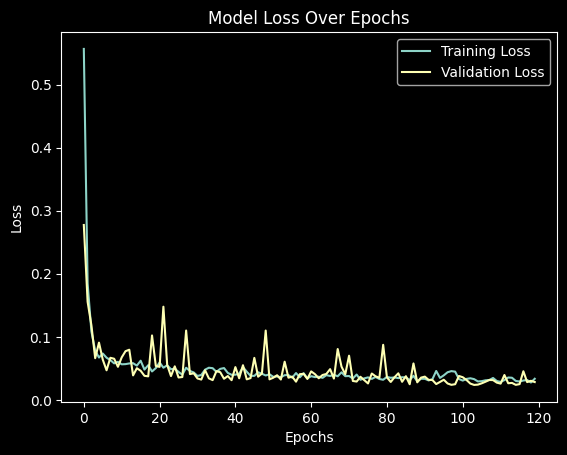

In [39]:
import json
import pandas as pd
import tensorflow as tf
import keras
from sklearn.model_selection import train_test_split, KFold
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.metrics import mean_squared_error
from keras.models import Sequential
from keras.layers import Dense, Dropout, Input
from keras.optimizers import Adam
from optuna.pruners import MedianPruner
from optuna.integration import KerasPruningCallback
import numpy as np
import matplotlib.pyplot as plt

# ----------------------------
# 1. Data Preprocessing
# ----------------------------

# SALEPRODUCTCODE를 기준으로 판매량 카운트 (판매량 = SALEPRODUCTCODE의 빈도)
union_df["SALE_COUNT"] = union_df.groupby("SALEPRODUCTCODE")[
    "SALEPRODUCTCODE"
].transform("count")
union_df["SALE_COUNT"] = pd.to_numeric(union_df["SALE_COUNT"], errors="coerce")
print(union_df["SALE_COUNT"].abs().sort_values(ascending=False).head(10))

# 수치형으로 변환 가능한 열을 변환
numeric_columns = ["TRAVELNIGHTCOUNT", "TRAVELDAYCOUNT", "SHOPPINGCENTERVISITCOUNT"]

# 각 열을 숫자형으로 변환
for col in numeric_columns:
    union_df[col] = pd.to_numeric(union_df[col], errors="coerce")

# Parsing DEPARTUREDAY as datetime with format inference
union_df["DEPARTUREDAY"] = pd.to_datetime(union_df["DEPARTUREDAY"], errors="coerce")

# Extracting hour and weekday for time-based analysis
union_df["WEEKDAY"] = union_df["DEPARTUREDAY"].dt.weekday

# 범주형 변수 인코딩 (OneHotEncoder 예시)
categorical_columns = [
    "AIRLINENAME",
    "ARRIVALAIRPORTCODE",
    "WEEKDAY",
    "FREEDOMSCHEDULEYN",
    "SUPPLIERCODE",
]
encoder = OneHotEncoder(sparse_output=False, handle_unknown="ignore")
encoded_categorical = encoder.fit_transform(union_df[categorical_columns].astype(str))

# 인코딩한 데이터프레임을 원래 데이터프레임에 추가
encoded_df_categorical = pd.DataFrame(
    encoded_categorical, columns=encoder.get_feature_names_out(categorical_columns)
)
encoded_df = pd.concat(
    [union_df.reset_index(drop=True), encoded_df_categorical.reset_index(drop=True)],
    axis=1,
)


# 'PRICEPRODUCT' 열에서 'A'의 amount를 추출하는 함수
def parse_A_amount(json_string):
    try:
        parsed_data = json.loads(json_string)
        for entry in parsed_data:
            if entry.get("ageDivisionCode") == "A":
                return float(entry.get("amount", 0))
    except (TypeError, json.JSONDecodeError, ValueError):
        return 0.0
    return 0.0


# 'PRICEPRODUCT' 열에서 'A'의 amount를 추출하여 새로운 'A_AMOUNT' 열 생성
encoded_df["A_AMOUNT"] = encoded_df["PRICEPRODUCT"].apply(parse_A_amount)

# ----------------------------
# 2. Feature Selection
# ----------------------------

# Define feature columns
features = ["TRAVELDAYCOUNT", "SHOPPINGCENTERVISITCOUNT", "A_AMOUNT"] + list(
    encoder.get_feature_names_out(categorical_columns)
)

# Define target variable
target = "SALE_COUNT"

# ----------------------------
# 3. Train-Test Split Based on SALEPRODUCTCODE
# ----------------------------

# Ensure 'SALEPRODUCTCODE' is present in 'encoded_df' for splitting
if "SALEPRODUCTCODE" not in encoded_df.columns:
    encoded_df = pd.concat(
        [encoded_df, union_df["SALEPRODUCTCODE"].reset_index(drop=True)], axis=1
    )

# SALEPRODUCTCODE 기준으로 중복되지 않도록 훈련/테스트 데이터 분리
unique_product_codes = union_df["SALEPRODUCTCODE"].unique()
train_codes, test_codes = train_test_split(
    unique_product_codes, test_size=0.3, random_state=23
)

# 훈련/테스트 데이터로 분리
train_df = encoded_df[encoded_df["SALEPRODUCTCODE"].isin(train_codes)].copy()
test_df = encoded_df[encoded_df["SALEPRODUCTCODE"].isin(test_codes)].copy()

# ----------------------------
# 4. Remove SALEPRODUCTCODE from Features
# ----------------------------

# 'SALEPRODUCTCODE' 열 삭제
train_df.drop("SALEPRODUCTCODE", axis=1, inplace=True)
test_df.drop("SALEPRODUCTCODE", axis=1, inplace=True)

# ----------------------------
# 5. Prepare Features and Target Variables
# ----------------------------

# 특성 및 타겟 변수 추출
X_train = train_df[features]
y_train = train_df[target]
X_test = test_df[features]
y_test = test_df[target]

# ----------------------------
# 6. Data Scaling
# ----------------------------

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# ----------------------------
# 6.5 Data Augmentation: Noise Injection (데이터 증강)
# ----------------------------

# 노이즈의 크기 설정 (노이즈의 표준편차 조절 가능)
noise_level = 0.01

# X_train_scaled에 노이즈를 추가하여 증강 데이터 생성
X_train_augmented = X_train_scaled + np.random.normal(0, noise_level, X_train_scaled.shape)

# 기존의 X_train_scaled와 증강된 X_train_augmented를 합침
X_train_combined = np.vstack([X_train_scaled, X_train_augmented])
y_train_combined = np.hstack([y_train, y_train])  # y_train을 두 번 반복하여 크기 맞춤

# 데이터 크기 확인
print("Original X_train_scaled shape:", X_train_scaled.shape)
print("Augmented X_train_combined shape:", X_train_combined.shape)
print("Original y_train shape:", y_train.shape)
print("Augmented y_train_combined shape:", y_train_combined.shape)

# ----------------------------
# 7. Handle Target Variable
# ----------------------------

# y_train_combined을 사용해 타겟 변수 설정
y_train_combined = pd.to_numeric(y_train_combined, errors="coerce")
y_test = pd.to_numeric(y_test, errors="coerce")

# numpy 배열로 변환
X_train_combined = np.array(X_train_combined)
X_test_scaled = np.array(X_test_scaled)
y_train_combined = np.array(y_train_combined)
y_test = np.array(y_test)

# ----------------------------
# 8. Data Cleaning to Prevent Errors
# ----------------------------

# Convert to float32
X_train_combined = X_train_combined.astype(np.float32)
X_test_scaled = X_test_scaled.astype(np.float32)
y_train_combined = y_train_combined.astype(np.float32)
y_test = y_test.astype(np.float32)

# Verify the shapes
print("X_train_combined shape:", X_train_combined.shape)
print("y_train_combined shape:", y_train_combined.shape)
print("X_test_scaled shape:", X_test_scaled.shape)
print("y_test shape:", y_test.shape)

# Final Data Integrity Checks:
print("\nFinal Data Integrity Checks:")
print("Any NaNs in X_train_combined:", np.isnan(X_train_combined).any())
print("Any Infs in X_train_combined:", np.isinf(X_train_combined).any())
print("Any NaNs in y_train_combined:", np.isnan(y_train_combined).any())
print("Any Infs in y_train_combined:", np.isinf(y_train_combined).any())

# ----------------------------
# 9. Additional Data Type and Structure Verification
# ----------------------------

# 데이터 타입 확인
print("\nData Types:")
print("X_train_combined dtype:", X_train_combined.dtype)
print("y_train_combined dtype:", y_train_combined.dtype)
print("X_test_scaled dtype:", X_test_scaled.dtype)
print("y_test dtype:", y_test.dtype)

# y_train_combined의 구조 확인
print("\ny_train_combined shape before reshape:", y_train_combined.shape)

# y_train_combined과 y_test를 1차원 배열로 재구성 (필요 시)
if len(y_train_combined.shape) > 1 and y_train_combined.shape[1] == 1:
    y_train_combined = y_train_combined.flatten()
    y_test = y_test.flatten()

print("y_train_combined shape after reshape:", y_train_combined.shape)
print("y_test shape after reshape:", y_test.shape)

# 데이터 타입 재확인
print("\nAfter conversion and reshaping:")
print("X_train_combined dtype:", X_train_combined.dtype)
print("y_train_combined dtype:", y_train_combined.dtype)
print("X_test_scaled dtype:", X_test_scaled.dtype)
print("y_test dtype:", y_test.dtype)

# ----------------------------
# 9.5. Cross-Validation Setup
# ----------------------------

def objective(trial):
    # 하이퍼파라미터 샘플링
    learning_rate = trial.suggest_loguniform("learning_rate", 1e-4, 1e-3)
    dropout_rate = trial.suggest_uniform("dropout_rate", 0.01, 0.3)
    n_layers = trial.suggest_int("n_layers", 3, 6)
    n_units = trial.suggest_int("n_units", 64, 128)
    batch_size = trial.suggest_categorical("batch_size", [8 ,16, 32])
    epochs = trial.suggest_categorical("epochs", [80, 100,120])

    # 교차 검증 설정
    kf = KFold(n_splits=5, shuffle=True, random_state=23)
    cv_rmse_scores = []

    # 교차 검증 루프
    for fold, (train_index, val_index) in enumerate(kf.split(X_train_combined)):
        # 훈련 및 검증 데이터 분리
        X_train_fold, X_val_fold = X_train_combined[train_index], X_train_combined[val_index]
        y_train_fold, y_val_fold = y_train_combined[train_index], y_train_combined[val_index]

        # 딥러닝 모델 생성
        model = Sequential()
        model.add(Input(shape=(X_train_fold.shape[1],)))

        # 샘플링된 수 만큼의 은닉층 추가
        for _ in range(n_layers):
            model.add(Dense(n_units, activation="relu"))
            model.add(Dropout(dropout_rate))
        
        model.add(Dense(1, activation="linear"))

        # 모델 컴파일
        model.compile(optimizer=Adam(learning_rate=learning_rate), loss="mean_squared_error")

        # pruning (조기종료) 기능 추가
        pruning_callback = KerasPruningCallback(trial, monitor='val_loss')

        # 모델 학습
        model.fit(
            X_train_fold,
            y_train_fold,
            epochs=epochs,
            batch_size=batch_size,
            validation_data=(X_val_fold, y_val_fold),
            callbacks=[pruning_callback],
            verbose=0,
        )

        # 검증 데이터로 예측 및 평가
        y_val_pred = model.predict(X_val_fold).flatten()
        val_rmse = np.sqrt(mean_squared_error(y_val_fold, y_val_pred))
        cv_rmse_scores.append(val_rmse)

    # 교차 검증에서의 평균 RMSE를 반환하여 최적화
    mean_rmse = np.mean(cv_rmse_scores)
    return mean_rmse

# Optuna 스터디 생성 및 최적화 실행
study_name = "test"
pruner = MedianPruner()
study = optuna.create_study(storage=f"sqlite:///{study_name}.db", study_name=study_name, direction="minimize", pruner=pruner)
study.optimize(objective, n_trials=50)  # 50번의 하이퍼파라미터 탐색 시도

# 최적의 하이퍼파라미터 출력
print("Best hyperparameters: ", study.best_params)
print("Best RMSE: ", study.best_value)

# ----------------------------
# 11. Final Evaluation on Test Data with Optimized Hyperparameters
# ----------------------------

# 최적의 하이퍼파라미터로 최종 모델 학습
best_params = study.best_params
model = Sequential()
model.add(Input(shape=(X_train_combined.shape[1],)))

# 샘플링된 수 만큼의 은닉층 추가
for _ in range(best_params["n_layers"]):
    model.add(Dense(best_params["n_units"], activation="relu"))
    model.add(Dropout(best_params["dropout_rate"]))

model.add(Dense(1, activation="linear"))

# 모델 컴파일
model.compile(
    optimizer=Adam(learning_rate=best_params["learning_rate"]),
    loss="mean_squared_error",
)

# 최적의 하이퍼파라미터로 모델 학습
history = model.fit(
    X_train_combined,
    y_train_combined,
    epochs=best_params["epochs"],
    batch_size=best_params["batch_size"],
    validation_split=0.2,
    verbose=1,
)

# 테스트 데이터로 예측
y_pred = model.predict(X_test_scaled).flatten()
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print(f"Final RMSE with optimized parameters: {rmse}")

# ----------------------------
# 12. Visualize Training History (Optional)
# ----------------------------

plt.plot(history.history["loss"], label="Training Loss")
plt.plot(history.history["val_loss"], label="Validation Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Model Loss Over Epochs")
plt.legend()
plt.show()

In [40]:
from sklearn.metrics import r2_score

# R-squared 계산
r2 = r2_score(y_test, y_pred)
print(f"XGBoost R-squared: {r2}")

XGBoost R-squared: -0.1506361961364746


In [ ]:
import pandas as pd

# 실제값과 예측값을 DataFrame으로 변환하여 비교
comparison_df = pd.DataFrame({"Actual": y_test, "Predicted": y_pred})

# 상위 20개의 샘플만 출력하여 비교
print(comparison_df.head(20))

# 차이를 계산하여 추가 (실제값 - 예측값)
comparison_df["Difference"] = comparison_df["Actual"] - comparison_df["Predicted"]

# 차이가 큰 상위 10개 샘플 출력 (절댓값 기준)
print("\nTop 10 samples with the highest differences:")
print(
    comparison_df.reindex(
        comparison_df["Difference"].abs().sort_values(ascending=False).index
    ).head(10)
)

In [35]:
import optuna
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Input
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler

# 스케일링
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Optuna 목적 함수 정의
def objective(trial):
    # 하이퍼파라미터 샘플링
    learning_rate = trial.suggest_loguniform("learning_rate", 1e-4, 1e-3)
    dropout_rate = trial.suggest_uniform("dropout_rate", 0.05, 0.1)
    n_layers = trial.suggest_int("n_layers", 2, 4)
    epochs = trial.suggest_categorical("epochs", [80, 100, 120])
    n_units = trial.suggest_int("n_units", 64, 96)
    batch_size = trial.suggest_categorical("batch_size", [16, 32, 64])

    # 모델 생성
    model = Sequential()
    model.add(Input(shape=(X_train_combined.shape[1],)))

    # 샘플링된 수 만큼의 은닉층 추가
    for _ in range(n_layers):
        model.add(Dense(n_units, activation="relu"))
        model.add(Dropout(dropout_rate))

    model.add(Dense(1, activation="linear"))

    # 모델 컴파일
    model.compile(
        optimizer=Adam(learning_rate=learning_rate), loss="mean_squared_error"
    )

    # 모델 학습
    history = model.fit(
        X_train_combined,
        y_train_combined,
        epochs=epochs,
        batch_size=batch_size,
        validation_split=0.2,
        verbose=0,  # Optuna 최적화 중에는 출력 억제
    )

    # 테스트 데이터로 예측
    y_pred = model.predict(X_test_scaled).flatten()

    # 성능 평가 (RMSE)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))

    return rmse

# Optuna 스터디 생성 및 최적화 실행
study = optuna.create_study(direction="minimize")  # RMSE를 최소화하는 방향으로 설정
study.optimize(objective, n_trials=50)  # 50번의 하이퍼파라미터 탐색 시도

# 최적의 하이퍼파라미터 출력
print("Best hyperparameters: ", study.best_params)
print("Best RMSE: ", study.best_value)

# ----------------------------
# 3. 최적의 하이퍼파라미터로 최종 모델 학습
# ----------------------------

# 최적의 하이퍼파라미터 사용하여 모델 재학습
best_params = study.best_params
best_epochs = best_params["epochs"]  # 최적화된 epochs 사용

model = Sequential()
model.add(Input(shape=(X_train_combined.shape[1],)))

# 샘플링된 수 만큼의 은닉층 추가
for _ in range(best_params["n_layers"]):
    model.add(Dense(best_params["n_units"], activation="relu"))
    model.add(Dropout(best_params["dropout_rate"]))

model.add(Dense(1, activation="linear"))

# 모델 컴파일
model.compile(
    optimizer=Adam(learning_rate=best_params["learning_rate"]),
    loss="mean_squared_error",
)

# 최적의 하이퍼파라미터로 모델 학습
history = model.fit(
    X_train_combined,
    y_train_combined,
    epochs=best_epochs,  # 최적화된 epochs 사용
    batch_size=best_params["batch_size"],
    validation_split=0.2,
    verbose=1,
)

# 최적 모델로 테스트 데이터 평가
y_pred = model.predict(X_test_scaled).flatten()
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print(f"Final RMSE with optimized parameters: {rmse}")

# ----------------------------
# 4. 학습 과정 시각화 (옵션)
# ----------------------------

plt.plot(history.history["loss"], label="Training Loss")
plt.plot(history.history["val_loss"], label="Validation Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Model Loss Over Epochs")
plt.legend()
plt.show()

[I 2024-10-21 13:01:04,511] A new study created in memory with name: no-name-29d17ddc-2a61-47cf-98e9-09c9d9d0e691
C:\Users\douly\AppData\Local\Temp\ipykernel_4344\3154681017.py:18: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-4, 1e-3)
C:\Users\douly\AppData\Local\Temp\ipykernel_4344\3154681017.py:19: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  dropout_rate = trial.suggest_uniform("dropout_rate", 0.05, 0.1)
[W 2024-10-21 13:01:05,806] Trial 0 failed with parameters: {'learning_rate': 0.0005392818032799786, 'dropout_rate': 0.09875958606816711, 'n_layers': 4, 'epochs': 100, 'n_units': 70, 'batch_size': 64} because of the follow

KeyboardInterrupt: 

In [31]:
from sklearn.metrics import r2_score

# R-squared 계산
r2 = r2_score(y_test, y_pred)
print(f"XGBoost R-squared: {r2}")

XGBoost R-squared: -0.11923372745513916


In [259]:
import tensorflow as tf

print("TensorFlow version:", tf.__version__)

TensorFlow version: 2.17.0


In [188]:
import optuna
import xgboost as xgb
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split


# object 타입을 float으로 변환 (필요시 적절한 형으로 변환)
X_train["TRAVELDAYCOUNT"] = pd.to_numeric(X_train["TRAVELDAYCOUNT"], errors="coerce")
X_train["SHOPPINGCENTERVISITCOUNT"] = pd.to_numeric(
    X_train["SHOPPINGCENTERVISITCOUNT"], errors="coerce"
)

X_test["TRAVELDAYCOUNT"] = pd.to_numeric(X_test["TRAVELDAYCOUNT"], errors="coerce")
X_test["SHOPPINGCENTERVISITCOUNT"] = pd.to_numeric(
    X_test["SHOPPINGCENTERVISITCOUNT"], errors="coerce"
)


# Optuna 하이퍼파라미터 최적화 함수 정의
def objective(trial):
    # 하이퍼파라미터 공간 설정
    params = {
        "n_estimators": trial.suggest_int("n_estimators", 30, 100),
        "learning_rate": trial.suggest_float("learning_rate", 0.01, 0.2),
        "max_depth": trial.suggest_int("max_depth", 2, 8),
        "subsample": trial.suggest_float("subsample", 0.5, 1),
        "colsample_bytree": trial.suggest_float("colsample_bytree", 0.6, 1),
        "gamma": trial.suggest_float("gamma", 0, 0.4),
        "reg_lambda": trial.suggest_float("reg_lambda", 0.3, 3.0),
        "random_state": 23,
        "objective": "reg:squarederror",
    }

    # 모델 학습 및 평가
    xgboost_model = xgb.XGBRegressor(**params)
    xgboost_model.fit(X_train, y_train)
    y_pred = xgboost_model.predict(X_test)
    mse = mean_squared_error(y_test, y_pred)
    return mse


# Optuna Study 객체 생성 및 최적화
study = optuna.create_study(direction="minimize")
study.optimize(objective, n_trials=500)  # n_trials: 시도할 하이퍼파라미터 조합 수

# 최적의 하이퍼파라미터 및 성능 확인
print(f"Best parameters found: {study.best_params}")
print(f"Best Mean Squared Error: {study.best_value}")

# 최적의 하이퍼파라미터로 모델 학습
best_params = study.best_params
best_model = xgb.XGBRegressor(**best_params)
best_model.fit(X_train, y_train)

# 테스트 데이터로 예측
y_pred_optuna = best_model.predict(X_test)

# 최적화된 모델 성능 평가 (평균 제곱 오차)
mse_optuna = mean_squared_error(y_test, y_pred_optuna)
print(f"XGBoost Mean Squared Error after Optuna tuning: {mse_optuna}")

C:\Users\douly\AppData\Local\Temp\ipykernel_46496\2465647498.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train["TRAVELDAYCOUNT"] = pd.to_numeric(X_train["TRAVELDAYCOUNT"], errors="coerce")
C:\Users\douly\AppData\Local\Temp\ipykernel_46496\2465647498.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train["SHOPPINGCENTERVISITCOUNT"] = pd.to_numeric(
C:\Users\douly\AppData\Local\Temp\ipykernel_46496\2465647498.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from 

Best parameters found: {'n_estimators': 43, 'learning_rate': 0.03564830286613658, 'max_depth': 2, 'subsample': 0.7231969876718171, 'colsample_bytree': 0.8245189612540754, 'gamma': 0.016978342039955272, 'reg_lambda': 0.30044999734947025}
Best Mean Squared Error: 2.300633027832298
XGBoost Mean Squared Error after Optuna tuning: 2.2936418137758214


In [20]:
from sklearn.metrics import r2_score

# R-squared 계산
r2 = r2_score(y_test, y_pred_optuna)
print(f"XGBoost R-squared: {r2}")

# 성능 평가 (평균 제곱 오차도 함께 출력)
mse_xgb = mean_squared_error(y_test, y_pred_optuna)
print(f"XGBoost Mean Squared Error: {mse_xgb}")

NameError: name 'y_pred_optuna' is not defined

In [186]:
import pandas as pd

# 실제값과 예측값을 DataFrame으로 변환하여 비교
comparison_df = pd.DataFrame({"Actual": y_test, "Predicted": y_pred_optuna})

# 상위 20개의 샘플만 출력하여 비교
print(comparison_df.head(20))

# 차이를 계산하여 추가 (실제값 - 예측값)
comparison_df["Difference"] = comparison_df["Actual"] - comparison_df["Predicted"]

# 차이가 큰 상위 10개 샘플 출력 (절댓값 기준)
print("\nTop 10 samples with the highest differences:")
print(
    comparison_df.reindex(
        comparison_df["Difference"].abs().sort_values(ascending=False).index
    ).head(10)
)

    Actual  Predicted
3        1   1.188272
20       1   1.169331
23       1   1.174421
24       1   1.169331
26       1   1.188272
27       2   1.188272
28       2   1.188272
29       1   1.169331
32       1   1.169331
41       1   1.169331
48       1   1.169331
53       1   1.169331
56       1   1.169331
62       1   1.169331
66       1   1.188272
68       1   1.174421
69       1   1.194837
77       1   1.174421
80       1   1.169331
83       1   1.188272

Top 10 samples with the highest differences:
     Actual  Predicted  Difference
102       8   1.169331    6.830669
103       8   1.169331    6.830669
109       8   1.169331    6.830669
112       8   1.169331    6.830669
106       8   1.169331    6.830669
100       8   1.169331    6.830669
114       8   1.169331    6.830669
119       8   1.169331    6.830669
99        6   1.169331    4.830669
110       6   1.169331    4.830669


In [155]:
print("X_train과 X_test의 중복 여부:", X_train.duplicated().sum())
print("Features와 y의 상관관계:\n", X.corrwith(y))
print("X_train 분포:\n", X_train.describe())
print("X_test 분포:\n", X_test.describe())

X_train과 X_test의 중복 여부: 26
Features와 y의 상관관계:
 TRAVELDAYCOUNT                -0.034734
SHOPPINGCENTERVISITCOUNT       0.339826
A_AMOUNT                      -0.171746
AIRLINENAME_AERO K AIRLINES   -0.006453
AIRLINENAME_LOT폴란드 항공         -0.015416
                                 ...   
WEEKDAY_4                     -0.004901
WEEKDAY_5                      0.015964
WEEKDAY_6                      0.029892
FREEDOMSCHEDULEYN_N           -0.175710
FREEDOMSCHEDULEYN_Y            0.175710
Length: 146, dtype: float64
X_train 분포:
        TRAVELDAYCOUNT  SHOPPINGCENTERVISITCOUNT      A_AMOUNT  \
count     1657.000000               1657.000000  1.657000e+03   
mean         5.261919                  1.326494  1.313602e+06   
std          1.790057                  1.469572  1.243449e+06   
min          2.000000                  0.000000  6.640000e+04   
25%          4.000000                  0.000000  5.499000e+05   
50%          5.000000                  1.000000  8.440000e+05   
75%          5.00

In [146]:
# 특성 중요도 출력
importances = model.feature_importances_
feature_importance_df = pd.DataFrame({"Feature": features, "Importance": importances})
feature_importance_df = feature_importance_df.sort_values(
    by="Importance", ascending=False
)
print(feature_importance_df)

                      Feature  Importance
2                    A_AMOUNT    0.306143
1    SHOPPINGCENTERVISITCOUNT    0.271119
101    ARRIVALAIRPORTCODE_ICN    0.129107
145       FREEDOMSCHEDULEYN_Y    0.060432
144       FREEDOMSCHEDULEYN_N    0.055589
..                        ...         ...
121    ARRIVALAIRPORTCODE_RUH    0.000000
119    ARRIVALAIRPORTCODE_PRG    0.000000
115    ARRIVALAIRPORTCODE_NGO    0.000000
135    ARRIVALAIRPORTCODE_XIY    0.000000
133    ARRIVALAIRPORTCODE_UBN    0.000000

[146 rows x 2 columns]
